# 0. Loading required libraries

First we load all the libraries needed for analysis. 

In [27]:
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm



# 1.  Testing for distribution shifts

In terms of hypothesis testing problems, the presence of distribution shifts can be modelled as testing for significant differences/effects. Asumme we observe two samples over variables $V$. We are now interested in understanding whether both samples are drawn from the same underlying distribution (i.e. if there is a distribution shift). Thus, we test the following hypothesis:
$$H_0:P_a(V) = P_b(V) \text{ vs } H_1:P_a(V) \neq P_b(V)\text{, where a and b denote the two different samples} $$


Let's examine this problem by focussing on an example. Taken from example 4.1 in [Plečko and Bareinboim (2024)](https://causalai.net/r90.pdf), we assume we have access to the hiring data of two startups from location A. Additionally, we observe the data for one startup at location B. The variables are given by:
- $Y \in \{0,1\}$, denoting the hiring decision {no,yes} 
- $X \in \{0,1\}$, denoting the applicant's gender {female,male}
- $Z \in \{0,1\}$, denoting the applicant's age group {young,old}
- $W \in \{0,1\}$, denoting whether the applicant holds a Phd {no,yes}

The underlying data-generating structural causal model (SCM) for location A is given by:
\begin{align*}
U &\leftarrow \textit{N}(0,1)\\
X &\leftarrow \textit{Bernoulli}(\text{expit}(U))\\ 
Z &\leftarrow \textit{Bernoulli}(\text{expit}(U))\\ 
W &\leftarrow \textit{Bernoulli}(0.3|X-Z| + 0.1)\\
Y &\leftarrow \textit{Bernoulli}(0.2(X+Z-2XZ) + 0.25W + 0.02) 
\end{align*}

Note that we adapted the original example such that:
- $W$ has parents $X$ and $Z$ 
- $Y$ has always non-zero probability of $Y=1$

Additionally, location B has a different mechanism for the hiring decision $Y$, given by:
\begin{align*}
Y &\leftarrow \textit{Bernoulli}(0.2(X+Z-2XZ) + 0.25W + 0.11) 
\end{align*}

In reality we usually only have access to the observational distribution over $V = \{X,Z,W,Y\}$ and not the underlying SCM. We now generate two samples for location A and one for location B.  
All samples are of size $n=1000$.

In [13]:
#Create sample hiring data

def hiring_data(shift, n=5000,d=0.09):
    
    np.random.seed(36)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
    Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02+d,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+(np.exp(U))),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2

sample_1, sample_2 = hiring_data(0)
_ , sample_3 = hiring_data(1)


In [26]:
import warnings
warnings.filterwarnings('ignore')

tv_sample_1 = sample_1[sample_1['X']==1]['Y'].mean() - sample_1[sample_1['X']==0]['Y'].mean()
print("tv",np.round(tv_sample_1,2))
x_de = 0
x_ie = 0
x_se = 0
for z in [0,1]:
    p_z_x0 = sample_1[sample_1['X']==0][sample_1['Z']==z].shape[0]/sample_1[sample_1['X']==0].shape[0]
    p_z_x1 = sample_1[sample_1['X']==1][sample_1['Z']==z].shape[0]/sample_1[sample_1['X']==1].shape[0]
    for w in [0,1]:
        p_w_x0_z  = sample_1[sample_1['X']==0][sample_1['Z']==z][sample_1['W']==w].shape[0]/sample_1[sample_1['X']==0][sample_1['Z']==z].shape[0]
        p_w_x1_z  = sample_1[sample_1['X']==1][sample_1['Z']==z][sample_1['W']==w].shape[0]/sample_1[sample_1['X']==1][sample_1['Z']==z].shape[0]
        p_y_x0_zw = sample_1[sample_1['X']==0][sample_1['Z']==z][sample_1['W']==w]['Y'].mean()
        p_y_x1_zw = sample_1[sample_1['X']==1][sample_1['Z']==z][sample_1['W']==w]['Y'].mean()

        x_de += (p_y_x1_zw - p_y_x0_zw)*p_z_x0*p_w_x0_z 
        x_ie += p_y_x1_zw*(p_w_x0_z-p_w_x1_z)*p_z_x0
        x_se += p_y_x1_zw*p_w_x1_z*(p_z_x0-p_z_x1)

print("x_de",np.round(x_de,2))
print("x_ie",np.round(x_ie,2))
print("x_se",np.round(x_se,2))

sum = x_de - x_ie - x_se
sum




tv 0.32
x_de 0.2
x_ie -0.08
x_se -0.04


0.3227726488784822

We are interested in testing whether the probability of an applicant being hired based on gender, age and education level is the same between pairs:
- Sample 1 vs Sample 2
- Sample 1 vs Sample 3  

As we have access to the true SCM, we know that the first pair represents location A and is drawn from the same distribution. The latter pair is drawn from different distributions. However, we will now try to answer the question solely based on observational data. Specifically we test the hypotheses:
\begin{align}
H_{0}: P_{s_1}(Y|X,Z,W) &= P_{s_2}(Y|X,Z,W)\quad \text{vs} \quad H_{1}: P_{s_1}(Y|X,Z,W) \neq P_{s_2}(Y|X,Z,W)\\
H_{0}: P_{s_1}(Y|X,Z,W) &= P_{s_3}(Y|X,Z,W)\quad \text{vs} \quad H_{1}: P_{s_1}(Y|X,Z,W) \neq P_{s_3}(Y|X,Z,W)\\
\end{align}
Generally, there is not a one-size-fits all solution to the problem and we need to choose task-specific procedures. In this case all variables are discrete and binary. Thus, one simple method for assessing the hypotheses is to perform a bootstrapped based test.

## 1.1 Bootstrap test

Note that in this case, both (1) and (2) can be rewritten to testing:
\begin{align*}
H_{0}: P_{s_1}(Y=1|X,Z,W) - P_{s_2}(Y=1|X,Z,W) &= 0 \quad \text{vs} \quad H_{1}: P_{s_1}(Y=1|X,Z,W) - P_{s_2}(Y=1|X,Z,W) \neq 0\\
H_{0}: P_{s_1}(Y=1|X,Z,W) - P_{s_3}(Y=1|X,Z,W) &= 0 \quad \text{vs} \quad H_{1}: P_{s_1}(Y=1|X,Z,W) - P_{s_3}(Y=1|X,Z,W) \neq 0\\
\end{align*}
Also, there are $2^3=8$ combinations of $X,Z$ and $W$. For each of these we can test the hypothesis whether the observed difference is significantly different from 0. However, let's first compute the corresponding conditionals for all samples.   

In [3]:
#compute conditionals of Y=1 on X,Z,W for all samples
y_conditional_on_xzw_sample_1 = sample_1.groupby(['X','Z','W'])['Y'].mean().reset_index()
y_conditional_on_xzw_sample_2 = sample_2.groupby(['X','Z','W'])['Y'].mean().reset_index()
y_conditional_on_xzw_sample_3 = sample_3.groupby(['X','Z','W'])['Y'].mean().reset_index()

#compare difference in conditionals
#between sample 1 vs sample 2
y_conditional_difference_sample_1_sample_2 = y_conditional_on_xzw_sample_1.merge(y_conditional_on_xzw_sample_2, on=['X','Z','W'], suffixes=('_s1','_s2'))
y_conditional_difference_sample_1_sample_2['Difference'] = y_conditional_difference_sample_1_sample_2['Y_s1'] - y_conditional_difference_sample_1_sample_2['Y_s2']
#between sample 1 vs sample 3
y_conditional_difference_sample_1_sample_3 = y_conditional_on_xzw_sample_1.merge(y_conditional_on_xzw_sample_3, on=['X','Z','W'], suffixes=('_s1','_s3'))
y_conditional_difference_sample_1_sample_3['Difference'] = y_conditional_difference_sample_1_sample_3['Y_s1'] - y_conditional_difference_sample_1_sample_3['Y_s3']

#Store the conditional probabilities as index
index = ['P(Y=1|X=0,Z=0,W=0)', 'P(Y=1|X=0,Z=0,W=1)', 'P(Y=1|X=0,Z=1,W=0)', 'P(Y=1|X=0,Z=1,W=1)', 'P(Y=1|X=1,Z=0,W=0)', 'P(Y=1|X=1,Z=0,W=1)', 'P(Y=1|X=1,Z=1,W=0)', 'P(Y=1|X=1,Z=1,W=1)']

print(f"Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 2 and their difference:\n\n{np.round(y_conditional_difference_sample_1_sample_2,4)}\n")
print(f"The average difference between sample 1 and sample 2 is {np.round(y_conditional_difference_sample_1_sample_2['Difference'].mean(),4)}\n")
print(f"Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 3 and their difference:\n\n{np.round(y_conditional_difference_sample_1_sample_3,4)}\n")
print(f"The average difference between sample 1 and sample 3 is {np.round(y_conditional_difference_sample_1_sample_3['Difference'].mean(),4)}\n")

Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 2 and their difference:

   X  Z  W    Y_s1    Y_s2  Difference
0  0  0  0  0.0118  0.0199     -0.0081
1  0  0  1  0.2195  0.3333     -0.1138
2  0  1  0  0.2795  0.2787      0.0008
3  0  1  1  0.4227  0.4894     -0.0667
4  1  0  0  0.2989  0.1920      0.1069
5  1  0  1  0.5000  0.5714     -0.0714
6  1  1  0  0.0256  0.0183      0.0073
7  1  1  1  0.1667  0.1739     -0.0072

The average difference between sample 1 and sample 2 is -0.019

Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 3 and their difference:

   X  Z  W    Y_s1    Y_s3  Difference
0  0  0  0  0.0118  0.1315     -0.1197
1  0  0  1  0.2195  0.4286     -0.2091
2  0  1  0  0.2795  0.3525     -0.0730
3  0  1  1  0.4227  0.5426     -0.1199
4  1  0  0  0.2989  0.2560      0.0429
5  1  0  1  0.5000  0.4615      0.0385
6  1  1  0  0.0256  0.1209     -0.0952
7  1  1  1  0.1667  0.2174     -0.0507

The average difference between sample 1 and sample

On a aggregated level we can see that the absolute difference is higher between sample 1 and sample 3 than between sample 1 and sample 2. This is in line with our knowledge of the underlying data-generating mechanisms. However, there are a few things to note.    

Although sample 1 and sample 2 are generated by the same SCM, the individual and average differences are $\neq0$. This is due to sampling variation as the SCM is not a fully deterministic process, but involves sampling from some probability distributions.    

This is also the reason as to why some absolute differences between sample 1 and sample 2 are higher than for sample 1 and sample 3.  

We now computed $P(Y=1| X,Z,W)$ for all samples and combinations of $X,Z$ and $W$. We now can test the initial hypothesis (1) and (2) by testing whether the observed differences for each individual conditional is significantly different from $0$. If there exists at least one individual conditional for which we can reject the null, we conclude that there must be a distribution shift between samples for $P(Y=1|X,Z,W)$.  

For instance, we test the following for sample 1 and sample 2.
\begin{align*} 
H_{0,1}: P_{s_1}(Y=1|X=0,Z=0,W=0) - P_{s_2}(Y=1|X=0,Z=0,W=0) = 0 \quad &\text{vs} \quad H_{1,1}: P_{s_1}(Y=1|X=0,Z=0,W=0) - P_{s_2}(Y=1|X=0,Z=0,W=0) \neq 0\\
H_{0,2}: P_{s_1}(Y=1|X=0,Z=0,W=1) - P_{s_2}(Y=1|X=0,Z=0,W=1) = 0 \quad &\text{vs} \quad H_{1,2}: P_{s_1}(Y=1|X=0,Z=0,W=1) - P_{s_2}(Y=1|X=0,Z=0,W=1) \neq 0\\
...\\
...\\
H_{0,8}: P_{s_1}(Y=1|X=1,Z=1,W=1) - P_{s_2}(Y=1|X=1,Z=1,W=1) = 0 \quad &\text{vs} \quad H_{1,3}: P_{s_1}(Y=1|X=1,Z=1,W=1) - P_{s_2}(Y=1|X=1,Z=1,W=1) \neq 0
\end{align*}
The same is applied for sample 1 vs sample 3. We will reject the null (samples coming from same distribution) if at least one of the individual conditionals is rejected.

We will leverage bootstrapping [[Tibshirani and Efron (1994)](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=duBlF_YAAAAJ&citation_for_view=duBlF_YAAAAJ:u5HHmVD_uO8C)] to asses this problem. Specifically, we will proceed as follows:    
\begin{align*}
\text{} \quad & \textbf{Bootstrap test} \ \\
\text{} \quad & \textbf{Input:} \ \text{samples a and b and observational distributions} P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of p-values, array of bootstrapped differences}  \\
\text{} \quad & \\
\text{1.} \quad & \text{for  all combinations of } X,Z,W \text{ do} \\
\text{2.} \quad & \quad \text{compute and store } d=P_a(Y=1|x,z,w) -P_b(Y=1|x,z,w)  \\
\text{3.} \quad & \text{for } 1:n_{bootstrap} \text{ do} \\
\text{4.} \quad & \quad  \text{Create pooled sample } \text{ from } a \text{ and } b\\
\text{5.} \quad & \quad \text{With replacement draw bootstrap samples } a^{boot},b^{boot} \text{ from pooled sample}\\
\text{6.} \quad & \quad \text{for  all combinations of } X,Z,W \text{ do} \\
\text{7.} \quad & \quad \quad \text{compute and store } d^{boot}=P_{a^{boot}}(Y=1|x,z,w) -P_{b^{boot}}(Y=1|x,z,w)  \\
\text{8.} \quad & \text{for  all combinations of } X,Z,W \text{ do} \\
\text{9.} \quad & \quad \text{compute and store } p=\frac{\#\{|d^{boot}| \geq |d|\}}{n_{bootstrap}}  \\
\end{align*} 
We rely on the notion of exchangeability to simulate the data under the null by pooling the two samples. The intuition being that if $a$ and $b$ are drawn from the same distribution, shuffling the data should not affect the overall statistical properties.  

Note that in our example, testing whether two conditional probabilities are the same, became a problem of performing 8 individual tests. Thus, we need to adjust for multiple testing which we will do by applying the Benjamini-Hochberg correction for the p-values.

In [ ]:
def bootstrap_test(sample_a,sample_b, B=10000):

    '''
    Function to perform bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    B: int, number of bootstrap iterations
    
    Returns:

    bootstrapped_diff: numpy array containing bootstrapped differences in conditional probabilities of Y=1 given X,Z,W between sample_a and sample_b
    p_values: numpy array for the individual hypothesis tests
    '''

    #compute difference in conditionals between sample_a and sample_b
    y_conditional_on_xzw_sample_a = sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_on_xzw_sample_b = sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_difference_sample_a_sample_b = y_conditional_on_xzw_sample_a['Y'].values - y_conditional_on_xzw_sample_b['Y'].values
    #empty array to store bootstrapped differences (8 x B)
    bootstrapped_diff = np.empty((8,B))
    #empty array to store p-values (8)
    p_values = np.zeros(8)
    #loop through B iterations
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):       
        #pool the samples
        pooled = pd.concat([sample_a, sample_b])
        #shuffle pooled data
        bootstrap_sample = pooled.sample(n=len(pooled), replace=True)
        #create bootstrap samples
        bootstrap_sample_a = bootstrap_sample.iloc[:len(sample_a)]
        bootstrap_sample_b = bootstrap_sample.iloc[len(sample_a):]
        #compute difference in conditionals between bootstrap_sample_a and bootstrap_sample_b
        y_conditional_on_xzw_bootstrap_sample_a = bootstrap_sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_on_xzw_bootstrap_sample_b = bootstrap_sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_difference_bootstrap_sample_a_sample_b = y_conditional_on_xzw_bootstrap_sample_a['Y'].values - y_conditional_on_xzw_bootstrap_sample_b['Y'].values
        #store bootstrapped difference
        bootstrapped_diff[:,i] = y_conditional_difference_bootstrap_sample_a_sample_b

    #compute p-values: fraction of absolute bootstrapped differences greater than absolute observed difference
    for i in range(8):
        p_values[i] = np.sum(np.abs(bootstrapped_diff[i]) >= np.abs(y_conditional_difference_sample_a_sample_b[i]))/B
    #Need to adjust for multiple testing
    bh_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]

    #return differences and p-values
    return bootstrapped_diff, p_values, bh_p_values

#perform the bootstrap test for sample 1 vs sample 2 and sample 1 vs sample 3
bootstrapped_diff_sample_1_sample_2, p_values_sample_1_sample_2,bh_p_values_sample_1_sample_2 = bootstrap_test(sample_1, sample_2)
bootstrapped_diff_sample_1_sample_3, p_values_sample_1_sample_3, bh_p_values_sample_1_sample_3 = bootstrap_test(sample_1, sample_3)

We first look at the comparison of sample 1 and sample 2. Given that they are generated by the same SCM, there should not be any significant differences

In [ ]:
#Histogram of bootstrapped differences for each tested conditional probability

fig, axes = plt.subplots(2,4, figsize=(20,10))
#Sample 1 vs Sample 2
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_2[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_2['Difference'][i], color='red', label='Observed')
    ax.set_title(f"No shift: differences in {index[i]}")
    #Add p-value
    ax.legend(title=f'p-value: {np.round(bh_p_values_sample_1_sample_2[i],4)}')
plt.tight_layout()
plt.show()

For sample 1 vs sample 2, the p-values for the differences in conditional probabilities of $Y=1$ given $X,Z,W$ are all greater than $0.05$, indicating that the differences are not statistically significant. This is consistent with the fact that they are generated from the same SCM. As this holds for all individual $P(Y=1|X,Z,W)$ we would conclude that we cannot detect a statistically significant distribution shift between the two samples with respect to the conditional probability of Y.  

We now examine the results for sample 1 vs sample 3. Given that they are generated from different SCMs we would expect to see at least one significant difference. Looking at the two different SCMs a bit more closely, we realisticalexpect all individual differences to be significant as the SCMs differ such that each individual conditional is affected by the shift.

In [ ]:
#Histogram of bootstrapped differences for each tested conditional probability
fig, axes = plt.subplots(2,4 , figsize=(20,10))
#Sample 1 vs Sample 3
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_3['Difference'][i], color='red', label='Observed')
    ax.set_title(f"Shift: differences in {index[i]}")
    #Add p-value
    ax.legend(title=f'p-value: {np.round(bh_p_values_sample_1_sample_3[i],4)}')
plt.tight_layout()
plt.show()

As at least one difference seems to be significantly different, we would reject the overall null hypothesis that the conditional of Y is the same for both samples. However, with the ground-truth being that all conditionals are affected by the shift, the test was only able to reject $\frac{3}{8}=37.5\%$ of all false nulls. This hints at low power of the test to detect shifted individual conditionals. A possible reason is that p-value corrections could lead to more conservative decisions compared to the unadjusted case. But, the unadjusted p-values are given by:

In [ ]:
print(f"The unadjusted p-values for sample 1 vs sample 3 are:\n{np.round(p_values_sample_1_sample_3,2)}\n")

Which would make the same decisions. A possible reason for the low power could also be that sampling variation dominates the distribution shift between sample 1 and sample 3 such that their difference is not detectable using the bootstrap test. The magnitude of shift between SCMs can be quantified exactly in this case and is given by   
\begin{align*}
d = P_{s_1}(Y=1|X,Z,W) - P_{s_3}(Y=1|X,Z,W) = 0.09
\end{align*}
We now repeat the test of sample 1 vs sample 3, but we change the following parameter:
- we change the SCMs such that we have a stronger shift of 0.5 and perform the test on the original sample size
- we keep the original SCMs and perform the test with increasing sample sizes [10,000;25,000;50,000]



In [ ]:
#Draw new sample 3 with d = 0.4
_ , sample_3_high_d = hiring_data(1, d=0.5)
#compute observed difference in conditionals between sample 1 and sample 3 with d = 0.4
y_conditional_diff_sample_1_sample_3_high_d = sample_1.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values - sample_3_high_d.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values 

#Draw samples 1 and 2 with increasing sample sizes (n=1000, 10000, 25000, 50000)
sample_1_10000, sample_3_10000 = hiring_data(1,n=10000)
#compute observed difference in conditionals between sample 1 and sample 3 with n=10000
y_conditional_diff_sample_1_sample_3_10000 = sample_1_10000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values - sample_3_10000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
sample_1_25000, sample_3_25000 = hiring_data(1,n=25000)
#compute observed difference in conditionals between sample 1 and sample 3 with n=25000
y_conditional_diff_sample_1_sample_3_25000 = sample_1_25000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values - sample_3_25000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
sample_1_50000, sample_3_50000 = hiring_data(1,n=50000)
#compute observed difference in conditionals between sample 1 and sample 3 with n=50000
y_conditional_diff_sample_1_sample_3_50000 = sample_1_50000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values - sample_3_50000.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values

#Perform bootstrap test for sample 1 vs sample 3 with d = 0.4
bootstrapped_diff_sample_1_sample_3_high_d, p_values_sample_1_sample_3_high_d, bh_p_values_sample_1_sample_3_high_d = bootstrap_test(sample_1, sample_3_high_d)


#Perform bootstrap test for sample 1 vs sample 2 with increasing sample sizes
bootstrapped_diff_sample_1_sample_3_10000, p_values_sample_1_sample_3_10000, bh_p_values_sample_1_sample_3_10000 = bootstrap_test(sample_1_10000, sample_3_10000)
bootstrapped_diff_sample_1_sample_3_25000, p_values_sample_1_sample_3_25000, bh_p_values_sample_1_sample_3_25000 = bootstrap_test(sample_1_25000, sample_3_25000)
bootstrapped_diff_sample_1_sample_3_50000, p_values_sample_1_sample_3_50000, bh_p_values_sample_1_sample_3_50000 = bootstrap_test(sample_1_50000, sample_3_50000)

Again, we visually inspect the tests.

In [ ]:
#Plot histograms for each of the tests performed:
## Sample 1 vs Sample 3 with d = 0.5
#4 histograms per row
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3_high_d[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(y_conditional_diff_sample_1_sample_3_high_d[i], color='red', label='Observed')
    ax.set_title(f'd = 0.5: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Difference in conditional probability')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_p_values_sample_1_sample_3_high_d[i]:.3f}')])

plt.tight_layout()
plt.show()



## Sample 1 vs Sample 2 with increasing sample sizes
##sample size 10000
#4 histograms per row
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3_10000[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(y_conditional_diff_sample_1_sample_3_10000[i], color='red', label='Observed')
    ax.set_title(f'n = 10,000: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Difference in conditional probability')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_p_values_sample_1_sample_3_10000[i]:.3f}')])

plt.tight_layout()
plt.show()


##sample size 25000
#4 histograms per row
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3_25000[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(y_conditional_diff_sample_1_sample_3_25000[i], color='red', label='Observed')
    ax.set_title(f'n = 25,000: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Difference in conditional probability')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_p_values_sample_1_sample_3_25000[i]:.3f}')])

plt.tight_layout()
plt.show()

##sample size 50000
#4 histograms per row
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3_50000[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(y_conditional_diff_sample_1_sample_3_50000[i], color='red', label='Observed')
    ax.set_title(f'n = 50,000: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Difference in conditional probability')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_p_values_sample_1_sample_3_50000[i]:.3f}')])

plt.tight_layout()
plt.show()

For a very strong shift in distribution (i.e. $P(Y=1|X,Z,W)$ having difference $d = 0.5$), the bootstrap is capable of detecting any of the 8 individual conditionals as shifted. Thus, it seems that for more pronounced shifts the bootstrap tests becomes more powerful in detecting more fine-grained shifts instead of only working on aggregate.

As for the sample size, increasing it 10-fold from 1k to 10k observations already allows the bootstrap approach to detect all individual shifts in the conditionals. With larger size, the individual samples become a more accurate representation of the underlying distribution and the effect of sample variation decreases. 

These two observations are important considerations, when choosing an appropiate method to detect dataset shifts. While in our example, the bootstrap test did not commit any Type I error, it was not able to detect all individual significant shifts. As the unadjusted p-values showed, it was not due to more conservative decisions when correcting for multiple testing. Instead, lower sample sizes and less pronounced shifts seem to have a negative influence on its power. A more theoretical power analysis could shed more light into this, but is beyond the scope of this work. Also, from an aggregate perspective which is our rationale for rejecting the null, for $n=1,000$, the test was able to detect at least one shifted conditional. While not capable of discovering all fine-granularities of shifts, it did suceed in pointing us towards significant differences in $Y=1|X,Z,W$. Thus, in all examples, we would have concluded that there is a shift between sample 1 and sample 3.

## 1.2 Chi-squared test

Remembering the initial problem, we were interested whether the two samples coincide in the conditional of $Y$ on $X,Z,W$. We did this by restructuring the problem into testing whether the conditional expectation of Y differs between the samples as in this case:
\begin{align*}
\text{E}[Y|X,Z,W] = P(Y=1|X,Z,W)
\end{align*}

We then bootstrapped the difference in expectation under the null. However, there are also methods that can go without resampling methods. For instance, the $\Chi^2$-Test, which is recommended by [Rabanser, Günneman and Liption (2019)](https://proceedings.neurips.cc/paper/2019/hash/846c260d715e5b854ffad5f70a516c88-Abstract.html) for dataset shifts in case of categorical data.

We can perform the test as follows:
\begin{align*}
\text{} \quad & \textbf{Chi-squared test} \ \\
\text{} \quad & \textbf{Input:} \ \text{samples a and b and observational distributions} P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of Chi-squared statistics, array of p-values}  \\
\text{} \quad & \\
\text{1.} \quad & \text{for  all combinations of } X,Z,W \text{ do} \\
\text{2.} \quad & \quad \text{compute and store counts of } Y=0 \text{ and } Y=1   \\
\text{3.} \quad & \text{Merge the contigency tables for both samples} \\
\text{4.} \quad & \text{for  all combinations of } X,Z,W \text{ do}\\
\text{5.} \quad & \quad \text{Perform Chi-Squared test and obtain statistic and p-value (i.e. using Scipy implementation)}\\
\end{align*} 

While we are overall interested in whether the conditional distribution of Y differs between samples, the $\Chi^2$-Test frames the hypotheses as:
\begin{align*}
H_0: \text{Group (sample) membership is independent of Y for each (X,Z,W) \quad vs\quad} H_1: \text{Group (sample) membership is not independent of Y for each (X,Z,W)}
\end{align*}
The phrasing might sound confusing at first. But, the null essentially conveyes that if we compare the outcome of $Y$ between the two samples (groups), if their conditional on (X,Z,W) is the same, their distribution should not depend on whether the outcome comes from sample 1 or sample 2. If they are not the same, we would expect their distribution to differ depending on belonging to sample 1 or sample 2 which is formulated in the alternative.   

Again, we have to break down the problem into performing 8 individual tests and adjust the p-values using Benjamini-Hochberg correction. For performing the actual $X^2$-test, we will use the Scipy implementation which only needs the contigency table as an input. 

In [ ]:
#Chi-squared test to compare the distribution of Y=1 given X,Z,W between samples

def chi_squared_test(sample_a, sample_b):

    '''
    Function to perform chi-squared test for difference in distribution of Y=1 given X,Z,W for two samples

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    
    Returns:

    chi_squared_stats: numpy array containing chi-squared statistics for each tested conditional probability
    p_values: numpy array for the individual hypothesis tests
    adjusted_p_values: numpy array for the adjusted p-values using Benjamini-Hochberg
    '''

    #compute counts of Y=1 and Y=0 for each combination of X,Z,W for both samples
    y_counts_sample_a = sample_a.groupby(['X','Z','W'])['Y'].value_counts().unstack().reset_index().fillna(0)
    y_counts_sample_b = sample_b.groupby(['X','Z','W'])['Y'].value_counts().unstack().reset_index().fillna(0)
    #merge the two contingency tables
    merged_counts = pd.merge(y_counts_sample_a, y_counts_sample_b, on=['X', 'Z', 'W'], suffixes=('_s1', '_s2'))
    #empty arrays to store chi-squared statistics and p-values
    chi_squared_stats = np.empty(8)
    p_values = np.zeros(8)
    #loop through each combination of X,Z,W
    for i, row in merged_counts.iterrows():
        #construct contingency table
        contingency_table = row[['0_s1', '1_s1', '0_s2', '1_s2']].values.reshape(2, 2)
        #perform chi-squared test
        chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
        chi_squared_stats[i] = chi2_stat
        p_values[i] = p_val

    #Need to adjust for multiple testing
    bh_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]

    #return chi-squared statistics and p-values
    return chi_squared_stats, p_values, bh_p_values


#perform chi-squared test for sample 1 vs sample 2 and sample 1 vs sample 3
chi_squared_stats_sample_1_sample_2, p_values_chi_squared_sample_1_sample_2, bh_p_values_chi_squared_sample_1_sample_2 = chi_squared_test(sample_1, sample_2)
chi_squared_stats_sample_1_sample_3, p_values_chi_squared_sample_1_sample_3, bh_p_values_chi_squared_sample_1_sample_3 = chi_squared_test(sample_1, sample_3)

#Summarise results in a table
sample_1_sample_2_chi_squared_results = pd.DataFrame({'Chi-squared statistics': chi_squared_stats_sample_1_sample_2, 'p-values': p_values_chi_squared_sample_1_sample_2, 'Adjusted p-values': bh_p_values_chi_squared_sample_1_sample_2})
sample_1_sample_2_chi_squared_results.index = index

sample_1_sample_3_chi_squared_results = pd.DataFrame({'Chi-squared statistics': chi_squared_stats_sample_1_sample_3, 'p-values': p_values_chi_squared_sample_1_sample_3, 'Adjusted p-values': bh_p_values_chi_squared_sample_1_sample_3})
sample_1_sample_3_chi_squared_results.index = index
print(f"Chi-squared test results for sample 1 vs sample 2:\n\n{np.round(sample_1_sample_2_chi_squared_results,4)}\n")
print(f"Chi-squared test results for sample 1 vs sample 3:\n\n{np.round(sample_1_sample_3_chi_squared_results,4)}\n")

We obtain a similar picture to the bootstrap. That is, the test correctly finds that sample 1 and sample 2 seem to be drawn from the same distribution as there are no rejected nulls. Comparing sample 1 and sample 3, the test is only able to detect $\frac{2}{8} = 12.5\%$ significant differences. Most notably, it succeeds/fails at the same conditionals as the bootstrap before. The intuition behind that is that testing 8 individual hypotheses leads to smaller sample sizes used for each test. The original $N=1,000$ are seperated into 8 groups. The grouping reduces the sample size used for each individual test and allows for sampling variation to dominate in the sub-problem. A more thorough power analysis might shed some light on this issue. As before, this is beyond the scope of this work.

We can repeat the test for increasing sample sizes. We will pay special attention to the individual sample sizes corresponding to each sub-problem. We begin by examining the individual sample sizes for the just performed test and then perform the test for increasing sample sizes again.

In [ ]:
#Track count of observations for each individual combination of X,Z,W
sample_1_counts = sample_1.groupby(['X','Z','W']).size().reset_index(name='Count')
sample_2_counts = sample_2.groupby(['X','Z','W']).size().reset_index(name='Count')
sample_3_counts = sample_3.groupby(['X','Z','W']).size().reset_index(name='Count')
#Merge all counts
merged_counts = sample_1_counts.merge(sample_2_counts, on=['X','Z','W'], suffixes=('_s1','_s2')).merge(sample_3_counts, on=['X','Z','W'])
merged_counts.columns = ['X','Z','W','Count_s1','Count_s2','Count_s3']
#Print
print(f"Counts of observations for each individual combination of X,Z,W for all samples:\n\n{merged_counts}\n")

#Perform test again for increasing sample sizes (only for sample 1 vs sample 3)
sample_1_n_10000, sample_3_n_10000 = hiring_data(1,n=10000)
sample_1_n_10000_counts, sample_3_n_10000_counts = sample_1_n_10000.groupby(['X','Z','W']).size().reset_index(name='Count'), sample_3_n_10000.groupby(['X','Z','W']).size().reset_index(name='Count')
merged_counts_n_10000 = sample_1_n_10000_counts.merge(sample_3_n_10000_counts, on=['X','Z','W'])
merged_counts_n_10000.columns = ['X','Z','W','Count_s1','Count_s3']
chi_squared_stats_sample_1_sample_3_n_10000, p_values_chi_squared_sample_1_sample_3_n_10000, bh_p_values_chi_squared_sample_1_sample_3_n_10000 = chi_squared_test(sample_1_n_10000, sample_3_n_10000)
merged_counts_n_10000['Adj. p-values'] = np.round(bh_p_values_chi_squared_sample_1_sample_3_n_10000,4)
print(f"Results for sample 1 vs sample 3 with N=10,000:\n\n{merged_counts_n_10000}\n")

sample_1_n_25000, sample_3_n_25000 = hiring_data(1,n=25000)
sample_1_n_25000_counts, sample_3_n_25000_counts = sample_1_n_25000.groupby(['X','Z','W']).size().reset_index(name='Count'), sample_3_n_25000.groupby(['X','Z','W']).size().reset_index(name='Count')
merged_counts_n_25000 = sample_1_n_25000_counts.merge(sample_3_n_25000_counts, on=['X','Z','W'])
merged_counts_n_25000.columns = ['X','Z','W','Count_s1','Count_s3']
chi_squared_stats_sample_1_sample_3_n_25000, p_values_chi_squared_sample_1_sample_3_n_25000, bh_p_values_chi_squared_sample_1_sample_3_n_25000 = chi_squared_test(sample_1_n_25000, sample_3_n_25000)
merged_counts_n_25000['Adj. p-values'] = np.round(bh_p_values_chi_squared_sample_1_sample_3_n_25000,4)
print(f"Results for sample 1 vs sample 3 with N=25,000:\n\n{merged_counts_n_25000}\n")

sample_1_n_50000, sample_3_n_50000 = hiring_data(1,n=50000)
sample_1_n_50000_counts, sample_3_n_50000_counts = sample_1_n_50000.groupby(['X','Z','W']).size().reset_index(name='Count'), sample_3_n_50000.groupby(['X','Z','W']).size().reset_index(name='Count')
merged_counts_n_50000 = sample_1_n_50000_counts.merge(sample_3_n_50000_counts, on=['X','Z','W'])
merged_counts_n_50000.columns = ['X','Z','W','Count_s1','Count_s3']
chi_squared_stats_sample_1_sample_3_n_50000, p_values_chi_squared_sample_1_sample_3_n_50000, bh_p_values_chi_squared_sample_1_sample_3_n_50000 = chi_squared_test(sample_1_n_50000, sample_3_n_50000)
merged_counts_n_50000['Adj. p-values'] = np.round(bh_p_values_chi_squared_sample_1_sample_3_n_50000,4)
print(f"Results for sample 1 vs sample 3 with N=50,000:\n\n{merged_counts_n_50000}\n")

We can notice that for the original example (i.e. $N=1,000$), the two individual conditionals which our previous tests correctly identified as different where also the ones where the corresponding subproblem had the largest and 2nd largest samples size. As we increase the sample size, we can again see that the tests is able to detect each individual difference.

We can also run the test again with the same large shift of $d=0.50$ between sample 1 and sample 3. 

In [ ]:
#Perform test again for sample 1 vs sample 3 with d = 0.5
chi_squared_stats_sample_1_sample_3_high_d, p_values_chi_squared_sample_1_sample_3_high_d, bh_p_values_chi_squared_sample_1_sample_3_high_d = chi_squared_test(sample_1, sample_3_high_d)
print(f"Chi-squared test results for sample 1 vs sample 3 with d = 0.5:\n\n{np.round(p_values_chi_squared_sample_1_sample_3_high_d,4)}\n")

As with the bootstrap, the $X^2$ test is able to detect all individual shifts if there is a more pronounced difference in the conditional of $Y$ between samples.

A preliminary summary so far could be that:
- Bootstrap and $X^2$-test did not reject true nulls (no shifts).
- Bootstrap and $X^2$-test are able to detect shifts between samples from a aggregate perspective (detect at least 1 significant shift in the conditionals)
- For individual conditionals, we see less rejections as expected. For moderate sample sizes and smaller shifts this might be an issue.
- Likely it is in part due to breaking the problem into 8 individual ones with possibly much smaller indvidual sample sizes.
- For large enough samples or very strong shifts, this does not seem to be a problem anymore.

In [ ]:
#Draw initial samples
sample_1, sample_2 = hiring_data(0)
#Draw new sample 3
_ , sample_3 = hiring_data(1,d=0.05)
#Pool samples
pool_s1s2 = pd.concat([sample_1, sample_2])
pool_s1s3 = pd.concat([sample_1, sample_3])
#add indicator for sample
pool_s1s2['Sample'] = ['Sample 1']*len(sample_1) + ['Sample 2']*len(sample_2)
pool_s1s3['Sample'] = ['Sample 1']*len(sample_1) + ['Sample 3']*len(sample_3)

#Perform Chi Squared Test of independence for Y independent of Sample conditional on X,Z,W

#Create contingency table stored in dictionary
contingency_table = {}

for i in range(2):
    for j in range(2):
        for k in range(2):
            name = f'X={i},Z={j},W={k}'
            contingency_table[name] = pool_s1s2[(pool_s1s2['X'] == i) & (pool_s1s2['Z'] == j) & (pool_s1s2['W'] == k)].groupby(['Sample','Y']).size().unstack().fillna(0).values

#Perform chi-squared test for each combination of X,Z,W
chi_squared_stats = {}
p_values = {}
for key in contingency_table.keys():
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table[key])
    chi_squared_stats[key] = chi2_stat
    p_values[key] = p_val

#adjust p-values
bh_p_values = multitest.multipletests(list(p_values.values()), method='fdr_bh')[1]

#Print results
print(f"Chi-squared test results for Y independent of Sample conditional on X,Z,W:\n")
for i, key in enumerate(p_values.keys()):
    print(f"{key}: p-value = {p_values[key]:.4f}, Adjusted p-value = {bh_p_values[i]:.4f}")




#Repeat for sample 1 vs sample 3
contingency_table = {}

for i in range(2):
    for j in range(2):
        for k in range(2):
            name = f'X={i},Z={j},W={k}'
            contingency_table[name] = pool_s1s3[(pool_s1s3['X'] == i) & (pool_s1s3['Z'] == j) & (pool_s1s3['W'] == k)].groupby(['Sample','Y']).size().unstack().fillna(0).values

#Perform chi-squared test for each combination of X,Z,W
chi_squared_stats = {}
p_values = {}
for key in contingency_table.keys():
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table[key])
    chi_squared_stats[key] = chi2_stat
    p_values[key] = p_val

#adjust p-values
bh_p_values = multitest.multipletests(list(p_values.values()), method='fdr_bh')[1]

#Print results
print(f"Chi-squared test results for Y independent of Sample conditional on X,Z,W:\n")
for i, key in enumerate(p_values.keys()):
    print(f"{key}: p-value = {p_values[key]:.4f}, Adjusted p-value = {bh_p_values[i]:.4f}")





We will continue by trying out 2 additional tests, before shifting our attention towards a more "non-traditional" approach. The 2 additional tests are:
- $Z$-test for proportions
- testing weighted outcomes as described in [Schrouff et al (2022)](https://proceedings.neurips.cc/paper_files/paper/2022/hash/7a969c30dc7e74d4e891c8ffb217cf79-Abstract-Conference.html)

## 1.3 Z-test for proportions

We begin with the $Z$-test. First, we notice that even without knowing the underlying data-generating mechanism one could assume that each observation in a sample corresponds to the outcome of a Bernoulli-Trial. The sample then corresponds to a sequence of $N$ individual Bernoulli-trials, which can be modelled with a binomial distribution $Binomial(n,p)$, where n corresponds to the number of samples and p the probability of success.  

For this example, we could assume the following for each individual observation and the overall sample:
\begin{align*}
Y_i \leftarrow Ber(p(X,W,Z))\\
Y \leftarrow Bin(n, p(X,W,Z))
\end{align*}

where, we assume that for both the individual observation and the overall sample the probability/number of successes for $Y$ depends on $X,W,Z$. For the probability of success, we can simply compute the empirical probability of success for all specific combinations of $(X,W,Z)$, while taking the number of samples available for that combination as our $n$. Thus, we model the conditional of $Y$ as:
\begin{align*}
Y=1 | X=x, W=w, Z=z \leftarrow \text{Bin}(n_{xwz}, \hat{p}(x,w,z))
\end{align*}

Further, given we have enough samples in the individual conditionals, it could allow for a Normal approxmiation. Let's begin by first computing the individual $\hat{p}(x,w,z)$ and $n_{xwz}$.


In [ ]:
#Bernoulli Trial
##compute p of success conditionally on X,Z,W for all samples
p_conditional_on_xzw_sample_1 = sample_1.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
p_conditional_on_xzw_sample_2 = sample_2.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
p_conditional_on_xzw_sample_3 = sample_3.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values

#Binomial Distribution
##compute number of samples for each combination of X,Z,W for all samples
n_sample_1 = sample_1.groupby(['X','Z','W']).size().reset_index(name='Count')['Count'].values
n_sample_2 = sample_2.groupby(['X','Z','W']).size().reset_index(name='Count')['Count'].values
n_sample_3 = sample_3.groupby(['X','Z','W']).size().reset_index(name='Count')['Count'].values

Using that we can perform a Z-test for
\begin{align*}
H_{0}: P_{s_1}(Y|X,Z,W) &= P_{s_2}(Y|X,Z,W)\quad \text{vs} \quad H_{1}: P_{s_1}(Y|X,Z,W) \neq P_{s_2}(Y|X,Z,W)\\
H_{0}: P_{s_1}(Y|X,Z,W) &= P_{s_3}(Y|X,Z,W)\quad \text{vs} \quad H_{1}: P_{s_1}(Y|X,Z,W) \neq P_{s_3}(Y|X,Z,W)\\
\end{align*}
by asessing the following hypotheses:
\begin{align*}
H_{0}: \hat{p}_{s_1}(x,w,z) &- \hat{p}_{s_2}(x,w,z) = 0\quad \text{vs} \quad H_{1}: \hat{p}_{s_1}(x,w,z) - \hat{p}_{s_2}(x,w,z) \neq 0\\
H_{0}: \hat{p}_{s_1}(x,w,z) &- \hat{p}_{s_3}(x,w,z) = 0\quad \text{vs} \quad H_{1}: \hat{p}_{s_1}(x,w,z) - \hat{p}_{s_3}(x,w,z) \neq 0\\
\end{align*}

In case of no shift, the difference between the sample proportions should not be significantly different from each other while the opposite should hold in presence of distribution shifts. We will perform two slightly different versions of the test. The first is the "standard" approach and is given by:
\begin{align*}
\text{} \quad & \textbf{Z-test for proportions} \ \\
\text{} \quad & \textbf{Input:} \ \text{samples a and b and observational distributions} P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of p-values}  \\
\text{} \quad & \\
\text{1.} \quad & \text{for both samples: }\text{ do} \\
\text{2.} \quad & \quad \text{Compute and store: } \hat{p}(Y=1|x,z,w) \text{ and }n_{xwz} \\
\text{3.} \quad & \text{Compute } d=\hat{p}_a(Y=1|x,z,w) - \hat{p}_b(Y=1|x,z,w) \\
\text{4.} \quad & \text{Compute } p^{pool} = \frac{n_{a_{xwz}}*\hat{p}_a(Y=1|x,z,w) + n_{b_{xwz}}*\hat{p}_b(Y=1|x,z,w)}{n_{a_{xwz}} + n_{b_{xwz}}} \\
\text{5.} \quad & \text{Compute the test statistic } z = \frac{d}{\sqrt{p^{pool}(1-p^{pool})(\frac{1}{n_{a_{xwz}}}+\frac{1}{n_{b_{xwz}}})}} \\
\text{6.} \quad & \text{Obtain p-values by } p = 2(1 − Φ(|z|), \text{where Φ(|z|) is the CDF of the standard Normal distribution.}\\
\end{align*} 


In [ ]:
#Perform the z-test for proportions for sample 1 vs sample 2 and sample 1 vs sample 3

def z_test(sample_a, sample_b):
    
    '''
    Function to perform z-test for difference in conditional probabilities of Y=1 given X,Z,W for two samples

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B

    Returns:

    z: numpy array containing z-statistics for each tested conditional probability
    p_values: numpy array for the individual hypothesis tests
    adjusted_p_values: numpy array for the adjusted p-values using Benjamini-Hochberg
    '''

    #compute empirircal probabilities of success and number of samples for each combination of X,Z,W for both samples
    p_sample_a = sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
    n_sample_a = sample_a.groupby(['X','Z','W']).size().reset_index(name='Count')['Count'].values
    p_sample_b = sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
    n_sample_b = sample_b.groupby(['X','Z','W']).size().reset_index(name='Count')['Count'].values
    #compute pooled p
    p_pooled = (p_sample_a*n_sample_a + p_sample_b*n_sample_b)/(n_sample_a + n_sample_b)
    #compute test statistic z
    z = (p_sample_a - p_sample_b)/np.sqrt(p_pooled*(1-p_pooled)*(1/n_sample_a + 1/n_sample_b))
    #compute p-values 
    p_values = 2*(1-norm.cdf(np.abs(z)))
    #Need to adjust for multiple testing
    bh_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]

    #return z-statistics and p-values
    return z, p_values, bh_p_values


#perform z-test for sample 1 vs sample 2 and sample 1 vs sample 3
z_stats_sample_1_sample_2, p_values_z_sample_1_sample_2, bh_p_values_z_sample_1_sample_2 = z_test(sample_1, sample_2)
z_stats_sample_1_sample_3, p_values_z_sample_1_sample_3, bh_p_values_z_sample_1_sample_3 = z_test(sample_1, sample_3)

#Summarise results in a table
sample_1_sample_2_z_results = pd.DataFrame({'Z statistics': z_stats_sample_1_sample_2, 'p-values': p_values_z_sample_1_sample_2, 'Adjusted p-values': bh_p_values_z_sample_1_sample_2})
sample_1_sample_2_z_results.index = index
sample_1_sample_3_z_results = pd.DataFrame({'Z statistics': z_stats_sample_1_sample_3, 'p-values': p_values_z_sample_1_sample_3, 'Adjusted p-values': bh_p_values_z_sample_1_sample_3})
sample_1_sample_3_z_results.index = index

#Print results
print(f"Z-test results for sample 1 vs sample 2:\n\n{np.round(sample_1_sample_2_z_results,4)}\n")
print(f"Z-test results for sample 1 vs sample 3:\n\n{np.round(sample_1_sample_3_z_results,4)}\n")


Essentially, the performance is in line with all previously tests. If there is no shift, the test does not reject the nulls. For a shift with magnitude $d=0.09$ it is only able to detect $\frac{3}{8}=37.5%$ of all individual shifts. As in real-life, we would only observe $P(X,W,Z,Y)$ without knowing the underlying SCM, we would correctly indicate that there is a shift from an aggregate perspective. For more pronounced shifts ($d=0.50$) and larger sample sizes, we would expect the test's power with respect to the individual conditionals to improve as it did with the previous methods. Thus, we will in this case not run the test again with larger shifts and samples (included in future appendix). Also, note that the test rejected the same nulls in presence of a shift as the previous tests. These, were again the conditionals with the largest individual sample sizes.

The z-test is parametric in the sense that assumes that the sampling distribution for the difference in proportions is approximately normal. Instead of only relying on our two available samples, we could also try to bootstrap the whole procedure by:
\begin{align*}
\text{} \quad & \textbf{Bootstrapped Z-test for proportions} \ \\
\text{} \quad & \textbf{Input:} \ \text{samples a and b and observational distributions} P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of (bootstrapped) Z statistics, array of p-values}  \\
\text{} \quad & \\
\text{1.} \quad & \text{for both samples }\text{ do:} \\
\text{2.} \quad & \quad \text{Compute and store: } \hat{p}(Y=1|x,z,w) \text{ and }n_{xwz} \\
\text{3.} \quad & \text{Compute } d=\hat{p}_a(Y=1|x,z,w) - \hat{p}_b(Y=1|x,z,w) \\
\text{4.} \quad & \text{Compute } p^{pool} = \frac{n_{a_{xwz}}*\hat{p}_a(Y=1|x,z,w) + n_{b_{xwz}}*\hat{p}_b(Y=1|x,z,w)}{n_{a_{xwz}} + n_{b_{xwz}}} \\
\text{5.} \quad & \text{Compute the test statistic } z = \frac{d}{\sqrt{p^{pool}(1-p^{pool})(\frac{1}{n_{a_{xwz}}}+\frac{1}{n_{b_{xwz}}})}} \\
\text{6.} \quad & \text{For } i:n_{boot}\text{\quad do:} \\
\text{7.} \quad & \quad \text{Pool samples a and b}\\
\text{8.} \quad & \quad \text{draw samples } a^{boot} \text{ and } b^{boot} \text{ from pooled sample with replacement}\\
\text{9.} \quad & \quad \text{for } a^{boot}, b^{boot}\text{ do:} \\
\text{10.} \quad & \quad \quad \text{repeat steps 2-5} \\
\text{11.} \quad &  \text{Compute p-values } p=\frac{\#\{|z^{boot} \geq z|\}}{n_{boot}} \\
\end{align*} 

We again assume exchangeability between samples under the null. Thus, we pool the samples again. The $z$-statistic is then bootstrapped under the null. We then compute the proportion of $z^{boot}$ which is at least as extreme as our observed $z$. The rationale is to compare how likely it is to obtain a $z$-statistic in the magnitude of the observed one assuming the null is true.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Number of bootstrap iterations
B = 10000
#empty arrays to store bootstrapped z-statistics
bootstrap_z_stats_sample_1_sample_2 = np.empty((8,B))
bootstrap_z_stats_sample_1_sample_3 = np.empty((8,B))

#loop through B iterations
for i in tqdm.tqdm(range(B), desc='Bootstrapping'):

    #sample 1 vs sample 2
    ##pool the samples
    pooled_bootstrap_sample = pd.concat([sample_1, sample_2])
    #shuffle pooled data
    bootstrap_sample = pooled_bootstrap_sample.sample(n=len(pooled_bootstrap_sample), replace=True)
    #create bootstrap samples
    bootstrap_sample_1 = bootstrap_sample.iloc[:len(sample_1)]
    bootstrap_sample_2 = bootstrap_sample.iloc[len(sample_1):]
    #perform z-test
    bootstrap_z_stats_sample_1_sample_2[:,i],_,_ = z_test(bootstrap_sample_1, bootstrap_sample_2)

    #sample 1 vs sample 3
    ##pool the samples
    pooled_bootstrap_sample = pd.concat([sample_1, sample_3])
    #shuffle pooled data
    bootstrap_sample = pooled_bootstrap_sample.sample(n=len(pooled_bootstrap_sample), replace=True)
    #create bootstrap samples
    bootstrap_sample_1 = bootstrap_sample.iloc[:len(sample_1)]
    bootstrap_sample_3 = bootstrap_sample.iloc[len(sample_1):]
    #perform z-test
    bootstrap_z_stats_sample_1_sample_3[:,i],_,_ = z_test(bootstrap_sample_1, bootstrap_sample_3)

#compute p-vals
bootstrap_p_values_sample_1_sample_2 = np.zeros(8)
bootstrap_p_values_sample_1_sample_3 = np.zeros(8)

for i in range(8):
    bootstrap_p_values_sample_1_sample_2[i] = np.sum(np.abs(bootstrap_z_stats_sample_1_sample_2[i,:]) >= np.abs(z_stats_sample_1_sample_2[i]))/B
    bootstrap_p_values_sample_1_sample_3[i] = np.sum(np.abs(bootstrap_z_stats_sample_1_sample_3[i,:]) >= np.abs(z_stats_sample_1_sample_3[i]))/B

#adjust for multiple testing
bh_bootstrap_p_values_sample_1_sample_2 = multitest.multipletests(bootstrap_p_values_sample_1_sample_2, method='fdr_bh')[1]
bh_bootstrap_p_values_sample_1_sample_3 = multitest.multipletests(bootstrap_p_values_sample_1_sample_3, method='fdr_bh')[1]

We can inspect the results and p-values visually.

In [ ]:
#Sample 1 vs Sample 2
fig, axs = plt.subplots(2,4, figsize=(20,10))
for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrap_z_stats_sample_1_sample_2[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(z_stats_sample_1_sample_2[i], color='red', label='Observed')
    ax.set_title(f'No Shift: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Z-statistic')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_bootstrap_p_values_sample_1_sample_2[i]:.3f}')])

plt.tight_layout()
plt.show()


#Sample 1 vs Sample 3
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(bootstrap_z_stats_sample_1_sample_3[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    ax.axvline(z_stats_sample_1_sample_3[i], color='red', label='Observed')
    ax.set_title(f'Shift: Differences in P(Y=1|X={y_conditional_difference_sample_1_sample_2["X"].values[i]}, Z={y_conditional_difference_sample_1_sample_2["Z"].values[i]}, W={y_conditional_difference_sample_1_sample_2["W"].values[i]})')
    ax.set_xlabel('Z-statistic')
    ax.set_ylabel('Frequency')
    # Create a legend without the p-value as a color-coded entry
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
               plt.Line2D([0], [0], color='red', lw=2, label='Observed')]
    
    # Add the p-value as a plain text
    ax.legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {bh_bootstrap_p_values_sample_1_sample_3[i]:.3f}')])

plt.tight_layout()
plt.show()

It  yields the same (non-)rejections as the base $Z$-test and previous tests before. For no shifts, no null is rejected. For a shift of $d=0.09$, the same significantly different proportions are detected in the $X^2$ and Bootstrap test. Again, for larger sample sizes or stronger shifts, we would expect the results to be closer to the ground-truth (in future appendix).


## 1.4 Conditional Independence Testing via weighted outcomes

We will now test an approach laid out by [Schrouff et al (2022)](https://proceedings.neurips.cc/paper_files/paper/2022/hash/7a969c30dc7e74d4e891c8ffb217cf79-Abstract-Conference.html), where the problem is reduced to testing:
\begin{align*}
& \text{H}_0: \text{E}[\hat{w}_aY|S=a] - \text{E}[\hat{w}_bY|S=b] = 0 \quad \text{vs} \quad \text{H}_1:\text{E}[\hat{w}_aY|S=a] - \text{E}[\hat{w}_bY|S=b] \neq 0
\end{align*}

where S=a or S=b in our example indicates whether a sample is coming from location a or location b. Essentially, the problem of testing conditional differences is reduced to testing whether weighted expected outcomes are different. The authors describe that the weights can be learned from the data as $\hat{w}_a = P(S=a|X,W,Z)^{-1}$ and similarly for $\hat{w}_b$. Their corresponding 'population' versions are $w_a = \frac{1}{P(X,W,Z|S=a)}$ and $w_b = \frac{1}{P(X,W,Z|S=b)}$ respectively.

 A formal derivation/description of the intuition behind this procedure will be in the write-up. The main idea is that given two samples, if we are weighting the outcomes $Y$ by the inverse probability of $pa(Y)$ for the corresponding sample, any difference in this weighted outcomes will be due to differences in $\sum_{x,w,z}E[Y|X=x,W=w,Z=z,S=s]$, where S=s indicates which sample (i.e. sample 1) we are referring to. The authors additionally use (iterated) expectations and the total expectation theorem to show that starting from $P(Y|X,W,Z,S=a) = P(Y|X,W,Z,S=b)$ the problem can be rewritten to comparing weighted outcomes of Y for both samples. 

 The testing algorithm as included in the paper is given by:

<img src="../images/CondIndepTesting_Schrouff.png" alt="Conditional Indep. Testing Schrouff et al" width="600"/>

A high-level description is that we split each sample into two groups:  
1. $D_w$: subsample for estimating the weights
2. $D_t$: subsample to apply the weights for and used for testing

Then, we resample the testing sets seperately using bootstrap. Assuming the variable we are testing (i.e.$Y$) has parents, we resample the weighting sets seperately using bootstrap. Then, we pool the bootstrapped weighting sets together and build a predictor $p(S|pa(Y))$ to seperate, for instance, whether an observation is coming from sample a or b. For comparing sample a and b we would have the following relationship:
\begin{align*}
P(S=a|pa(Y)) = 1 - P(S=b|pa(Y)) 
\end{align*} 
The inverse probabilities applied to the observations from the  bootstrapped testing sets are then used as our weights. Using the weights, we then compute the t-statistics for differences in the weighted means. While the algorithm does not explicitly mention how the p-values are obtained, the supplemental material explains that the authors use a two-sided $Z$-test for testing whether the resulting bootstraps t-statistics distribution's mean is significantly different from zero. The intuition is that if two samples are drawn from the same distribution, the bootstrapped t-statitics should center around 0.

We could compute the weights with different approaches. For instance:

1. Empirical weights: based of the pooled sample we could simply compute empirical versions of $w_a$ and $w_b$.
2. Logistic regression: fit a logistic regression with the sample indicator being the outcome and $X,W,Z$ being the predictors

Note, that is also possible to use more complex models (tree-based, neural-nets) to estimate the weights depending on the expected complexity of the relationship.

The former is non-parametric and data-driven. However, the resulting weights would be discrete in the sense that we have 8 different weights for each sample (i.e. one for each ($X,W,Z$) combination). 
As we've done that before, we will now try to work with a model-based approach. Thus, we will try logistic regression at first. Let's start by just fitting a logistic regression on the overall pooled samples to see how well it works in distinguishing between samples. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Assume we use a split of 0.75 for estimating the weights using logistic regression
split = 0.75
##Split the samples
sample_1_weights = sample_1.sample(frac=split)
sample_2_weights = sample_2.sample(frac=split)
sample_3_weights = sample_3.sample(frac=split)

#Fit logistic regression model to estimate weights
#Sample 1 vs Sample 2
##Pool the samples
pooled_weights = pd.concat([sample_1_weights, sample_2_weights])
##Add sample indicator
pooled_weights['Sample'] = ['Sample 1']*len(sample_1_weights) + ['Sample 2']*len(sample_2_weights)
##Feature matrix X with intercept
X = sm.add_constant(pooled_weights[['X','Z','W']])
##Target vector Y with sample 1 as reference
Y = (pooled_weights['Sample'] == 'Sample 2').astype(int)
##Fit logistic regression model
logit_model_s1s2 = sm.Logit(Y, X)
print(f"Logistic regression model for sample 1 vs sample 2:\n\n{logit_model_s1s2.fit().summary()}\n")

#Sample 1 vs Sample 3
##Pool the samples
pooled_weights = pd.concat([sample_1_weights, sample_3_weights])
##Add sample indicator
pooled_weights['Sample'] = ['Sample 1']*len(sample_1_weights) + ['Sample 3']*len(sample_3_weights)
##Feature matrix X with intercept
X = sm.add_constant(pooled_weights[['X','Z','W']])
##Target vector Y with sample 1 as reference
Y = (pooled_weights['Sample'] == 'Sample 3').astype(int)
##Fit logistic regression model
logit_model_s1s3 = sm.Logit(Y, X)
print(f"Logistic regression model for sample 1 vs sample 3:\n\n{logit_model_s1s3.fit().summary()}\n")


Interestingly enough, we see for both cases (Sample 1 vs Sample 2 and Sample 1 vs Sample 3) that the specified log. regression is not better than the null model. And this makes sense. Given that the weights are supposed to estimate $P(X,W,Z|S=s)$, and across all samples $P(X,W,Z)$ does not differ, the logistic regression should not really be able to distinguish between different samples. Hence, we should expect weights to be similar between samples in cases where $pa(Y)$ are not affected by shifts.

In [ ]:
#Extract weights for sample 1 vs sample 2
##get remaining samples for testing
sample_1_remaining = sample_1[~sample_1.index.isin(sample_1_weights.index)]
X = sm.add_constant(sample_1_remaining[['X','Z','W']])
##extract probabilities
p_s1s2 = logit_model_s1s2.fit(disp=0).predict(X)
p_s1 = 1-p_s1s2
p_s2 = p_s1s2
w_s1 = 1/p_s1
w_s2 = 1/p_s2
print(f'Average weight for sample 1: {np.mean(w_s1):.4f}\nAverage weight for sample 2: {np.mean(w_s2):.4f}\n')

#Extract weights for sample 1 vs sample 3
##get remaining samples for testing
sample_1_remaining = sample_1[~sample_1.index.isin(sample_1_weights.index)]
X = sm.add_constant(sample_1_remaining[['X','Z','W']])
##extract probabilities
p_s1s3 = logit_model_s1s3.fit(disp=0).predict(X)
p_s1 = 1-p_s1s3
p_s3 = p_s1s3
w_s1 = 1/p_s1
w_s3 = 1/p_s3
print(f'Average weight for sample 1: {np.mean(w_s1):.4f}\nAverage weight for sample 3: {np.mean(w_s3):.4f}\n')

We see that the weights are very similar between samples. Thus, any significant difference in $E[\hat{w}Y]$ will be attributable to differences in $Y$ between samples. Also, the paper does not really mention whether or not the weights are normalized or not. The supplemental material hints at that, but does not explicitly state it. However to avoid excessively large t-values we will normalize the weights as:
\begin{align*}
\hat{w}^{norm}_i &=\frac{\hat{w}_i}{\sum_i\hat{w}_i}\\
\end{align*}

Now, we are ready to perform the test as described in the paper. We will begin with a split of $0.75$ (i.e. $75\%$ of observations used for weight estimation) between weight and testing set. Besides the bootstrapped t-statistics, we will also inspect the probabilities assigned to observations being from a specific sample, and the weighted outcomes. 

In [ ]:

#Define function to perform weighted bootstrap test
def weighted_outcomes_bootstrap_test_schrouff(sample_a,sample_b, causal_parents_source, B=10000, split=0.75):

    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty(B)
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2,B))
    bootstrapped_weighted_outcome = np.empty((2,B))
    bootstrapped_pooled_se = np.empty(B)

    #Step2: perform bootstrap
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        #Test, for each bootstrap iteration have a different set for weights and testing
        #Step 2.1: Sample with replacement from the weights and testing
        bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
        bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
        bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
        bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

        #Step 2.2: Fit logistic regression model to estimate weights
        ##Pool the samples
        pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
        ##Add sample indicator
        pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
        ##Feature matrix X with intercept
        X = sm.add_constant(pooled_weights[causal_parents_source])
        ##Target vector Y with sample 1 as reference
        Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
        ##Fit logistic regression model
        logit_model = sm.Logit(Y, X).fit(disp=0)
        ##extract weights on testing set
        X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
        X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
        p_a = logit_model.predict(X_a)
        p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
        p_b = logit_model.predict(X_b)
        #Store the mean probability for p_a
        bootstrapped_mean_probabilities[i] = np.mean(p_a)
        if np.any(p_a == 0) or np.any(p_b == 0):
            print('Warning: Zero values in p_a or p_b')
        if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
            print('Warning: Near-zero values in p_a or p_b')
        #Compute the weights
        w_a = 1/p_a
        w_b = 1/p_b
        #Normalize the weights
        w_a_norm = w_a/np.sum(w_a)
        w_b_norm = w_b/np.sum(w_b)
        #Check for nans and infs
        if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
            print('Warning: NaN values in w_a or w_b')
        if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
            print('Warning: Inf values in w_a or w_b')
        #Check for very small values
        if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
            print('Warning: Near-zero values in w_a or w_b')
        
        #Compute hadamard product
        Y_a = bootstrap_sample_a_testing['Y'].values
        Y_b = bootstrap_sample_b_testing['Y'].values
        product_a = w_a_norm.values*Y_a
        product_b = w_b_norm.values*Y_b
        together = np.concatenate([product_a,-product_b])
        bootstrapped_t_stats[i] = ttest_1samp(together, 0)[0]
        #Compute and store weighted means
        bootstrapped_weighted_outcome[0,i] = np.sum(product_a)
        bootstrapped_weighted_outcome[1,i] = np.sum(product_b)
        #Compute and store mean weights
        bootstrapped_weights_mean[0,i] = np.mean(w_a)
        bootstrapped_weights_mean[1,i] = np.mean(w_b)

    #Step 3: Compute p-values
    mean = np.mean(bootstrapped_t_stats)
    std = np.std(bootstrapped_t_stats)
    p_value = (2*norm.cdf(-abs(mean/std)))

    return bootstrapped_t_stats, p_value,bootstrapped_weighted_outcome,bootstrapped_mean_probabilities, bootstrapped_weights_mean


#Perform the test for sample 1 vs sample 2 and sample 1 vs sample 3
#Draw the initial samples again
sample_1, sample_2 = hiring_data(0,n=1000)
_, sample_3 = hiring_data(1)

causal_parents_source = ['X','Z','W']
bootstrapped_t_stats_s1s2, p_value_s1s2, bootstrapped_weighted_outcomes_s1s2,mean_bootstrapped_probabilities_s1s2,bootstrapped_weights_mean_s1s2 = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,split=0.75,B=20000)
bootstrapped_t_stats_s1s3, p_value_s1s3, bootstrapped_weighted_outcomes_s1s3,mean_bootstrapped_probabilities_s1s3,bootstrapped_weights_mean_s1s3 = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=0.5,B=20000)

Let's inspect the results.

In [ ]:
#Histograms of bootstrapped t-statistics
fig, axs = plt.subplots(1,2, figsize=(20,5))
axs[0].hist(bootstrapped_t_stats_s1s2, bins=50, alpha=0.3, label='Bootstrapped', color='blue')
axs[0].axvline(np.mean(bootstrapped_t_stats_s1s2), color='red', label='Mean')
axs[0].set_title('Sample 1 vs Sample 2')
axs[0].set_xlabel('T-statistic')
axs[0].set_ylabel('Frequency')
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_s1s2:.3f}')])

# Add the p-value as a plain text

axs[1].hist(bootstrapped_t_stats_s1s3, bins=50, alpha=0.3, label='Bootstrapped', color='blue')
axs[1].axvline(np.mean(bootstrapped_t_stats_s1s3), color='red', label='Mean')
axs[1].set_title('Sample 1 vs Sample 3')
axs[1].set_xlabel('T-statistic')
axs[1].set_ylabel('Frequency')
# Create a legend without the p-value as a color-coded entry
handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
              plt.Line2D([0], [0], color='red', lw=2, label='Mean')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_value_s1s3:.3f}')])


plt.tight_layout()
plt.show()


#Histograms of bootstrapped probabilities
fig, axs = plt.subplots(1,2, figsize=(20,5))


axs[0].hist(mean_bootstrapped_probabilities_s1s2, bins=50, alpha=0.3, label='Bootstrapped', color='blue')
axs[0].axvline(np.mean(mean_bootstrapped_probabilities_s1s2), color='red', label='Mean')
axs[0].set_title('P(Sample 1)')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Frequency')

axs[1].hist(mean_bootstrapped_probabilities_s1s3, bins=50, alpha=0.3, label='Bootstrapped', color='blue')
axs[1].axvline(np.mean(mean_bootstrapped_probabilities_s1s3), color='red', label='Mean')
axs[1].set_title('P(Sample 1)')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#Histograms of weighted outcomes
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].hist(bootstrapped_weighted_outcomes_s1s2[0], bins=50, alpha=0.3, label='Sample 1', color='blue')
axs[0].hist(bootstrapped_weighted_outcomes_s1s2[1], bins=50, alpha=0.3, label='Sample 2', color='red')
#Add vertical lines for means
axs[0].axvline(np.mean(bootstrapped_weighted_outcomes_s1s2[0]), color='blue', label='Mean Sample 1')
axs[0].axvline(np.mean(bootstrapped_weighted_outcomes_s1s2[1]), color='red', label='Mean Sample 2')
axs[0].set_title('Weighted Means')
axs[0].set_xlabel('Weighted Mean')
axs[0].set_ylabel('Frequency')
#Add means 
axs[0].legend([f'Mean Sample 1: {np.mean(bootstrapped_weighted_outcomes_s1s2[0]):.3f}', f'Mean Sample 2: {np.mean(bootstrapped_weighted_outcomes_s1s2[1]):.3f}'])



axs[1].hist(bootstrapped_weighted_outcomes_s1s3[0], bins=50, alpha=0.3, label='Sample 1', color='blue')
axs[1].hist(bootstrapped_weighted_outcomes_s1s3[1], bins=50, alpha=0.3, label='Sample 3', color='red')
#Add vertical lines for means
axs[1].axvline(np.mean(bootstrapped_weighted_outcomes_s1s3[0]), color='blue', label='Mean Sample 1')
axs[1].axvline(np.mean(bootstrapped_weighted_outcomes_s1s3[1]), color='red', label='Mean Sample 2')
axs[1].set_title('Weighted Means')
axs[1].set_xlabel('Weighted Mean')
axs[1].set_ylabel('Frequency')
#Add means
axs[1].legend([f'Mean Sample 1: {np.mean(bootstrapped_weighted_outcomes_s1s3[0]):.3f}', f'Mean Sample 3: {np.mean(bootstrapped_weighted_outcomes_s1s3[1]):.3f}'])


plt.tight_layout()
plt.show()

We see that the test is not able to detect a significant shift between samples 1 and sample 3, while it does not commit the error of rejecting the null between sample 1 and sample 2

Furthermore, as expected the probabilities of the logistic regression for an observation being from sample 1 is around $50\%$ for both comparisons. This is not surprising as the probabilities and weights depend on $P(X,W,Z)$. In this example, this joint probability is not affected by any shifts. Thus, the logistic regression and thus the weights should not really be able to distinguish between both samples.

Another interesting observation is that the procedure quantifies the difference in weighted means between sample 1 and sample 2 as roughly $0.012$, which given they are generated using the same SCM is quite good. 

However, the problem still remains that the significant shift was not detected.

The split between data used for weights estimation and testing followed a recommendation of the authors to allocate as many samples as possible for weight estimation. However, in all examples featured in the paper/supplemental, the sample size was comfortably $>10,000$. Here, we assumed $n=1,000$. Thus, one might have some skepticism with either very small splits (i.e. $s \leq 0.2$) or very high splits (i.e. $s \geq 0.8$). The skepticism is rooted in the intuition that if we only use a very small or very large fraction for weight estimation and testing there is a chance that one of the two sets will not be representative enough of the actual sample.

For instance, assume that the weighting set is relatively small (i.e. $s=0.2$). In this case, we woud use 200 observations for each sample. Now assume, out of these only 20 observations are attributable to the conditional ($X=1,Z=0,W=1$) even though there are a total of 150 observations (dummy example) of it in sample a. If there are $> 20$ observations corresponding to that conditional in the weight set for sample b, the weighting procedure might conclude that these observations are more likely to occur in sample b than in sample a, even though the overall occurences for ($X=1,Z=0,W=1$) might be lower in sample b compared to sample a. This can lead to inaccurate weights, which has repercussions for the computed t-statistics and test decision. Similarly, for large splits, it might be the case that the observations in the testing set are not well represented during weighting. This also can lead to inaccurate weights with negative consequences for the computed statistics and test decision made.

Thus, we will perform the test again for a different number of splits starting from $s=0.1$ with increments of $+0.1$ until we end with $s=0.9$. We will pay a special attention to whether the splits might have an influence on the tests power.

In [ ]:
#list of splits
s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
B = 10000
#empty arrays to store results
bootstrapped_t_stats_s1s3_splits = np.empty((len(s),B)) 
p_values_s1s3_splits = np.empty(len(s))
bootstrapped_weighted_means_s1s3_splits = np.empty((len(s),2,B))    
causal_parents_source = ['X','Z','W']
p_values_s1s3_splits = np.empty(len(s))
#loop through splits
for i in range(len(s)):
    
    #Obtain bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats_s1s3_splits[i], p_values_s1s3_splits[i], bootstrapped_weighted_means_s1s3_splits[i],_,_   = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=s[i])
    #print(f" z-statistic for sample 1 vs sample 3 with split = {s[i]}: {p_values_s1s3_splits[i]:.4f}\n p-value for sample 1 vs sample 3 with split = {s[i]}: {p_values_s1s3_splits[i]:.4f}\n")

In [ ]:
#Histogram of bootstrapped t-statistics for different splits
fig, axs = plt.subplots(3,3, figsize=(20,10))

for i in range(len(s)):

    axs[i//3,i%3].hist(bootstrapped_t_stats_s1s3_splits[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    #Add mean t-statistic
    axs[i//3,i%3].axvline(np.mean(bootstrapped_t_stats_s1s3_splits[i]), color='green', label='Mean')
    axs[i//3,i%3].set_title(f'Shift: Bootstrapped t-statistics with split = {s[i]}')
    axs[i//3,i%3].set_xlabel('Bootstrapped t-statistic')
    axs[i//3,i%3].set_ylabel('Frequency')
    #Add p-value as a plain text
    axs[i//3,i%3].legend([f'p-value: {p_values_s1s3_splits[i]:.4f}'])

plt.tight_layout()
plt.show()


#Histogram of weighted means for different splits
fig, axs = plt.subplots(3,3, figsize=(20,10))

for i in range(len(s)):
    axs[i//3,i%3].hist(bootstrapped_weighted_means_s1s3_splits[i][0], bins=50, alpha=0.3, label='Sample 1', color='blue')
    axs[i//3,i%3].hist(bootstrapped_weighted_means_s1s3_splits[i][1], bins=50, alpha=0.3, label='Sample 3', color='red')
    #Add mean t-statistic
    axs[i//3,i%3].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]), color='green', label='Mean Weights Sample 1')
    axs[i//3,i%3].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]), color='purple', label='Mean Weights Sample 3')
    axs[i//3,i%3].set_title(f'Shift: Bootstrapped weighted means with split = {s[i]}')
    axs[i//3,i%3].set_xlabel('Bootstrapped mean weight')
    axs[i//3,i%3].set_ylabel('Frequency')
    axs[i//3,i%3].legend([f'Mean Weights Sample 1: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]):.4f}', f'Mean Weights Sample 3: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]):.4f}'])

plt.tight_layout()
plt.show()

Interestingly, we see for $s=0.8$ that the test is not able to detect a significant shift. This might support the intuition that higher/lower splits lead to decreased power if the original sample sizes are small. However, it is important to note that for the more extreme splits of $s=0.1$ and $s=0.9$, the test detected significant shifts. This gives an inconclusive result as to which split to choose for our example. 

We will repeat the procedure for the different splits for the case of no shifts (Sample 1 and Sample 2) to see if specific splits might lead to type I errors.

In [ ]:
#list of splits
s = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
B = 10000
#empty arrays to store results
bootstrapped_t_stats_s1s2_splits = np.empty((len(s),B)) 
p_values_s1s2_splits = np.empty(len(s))
bootstrapped_weighted_means_s1s2_splits = np.empty((len(s),2,B))  
p_values_s1s2_splits = np.empty(len(s))  
causal_parents_source = ['X','Z','W']
#loop through splits
for i in range(len(s)):
    
    #Obtain bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats_s1s2_splits[i], p_values_s1s2_splits[i], bootstrapped_weighted_means_s1s2_splits[i],_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,split=s[i])
    #print(f" z-statistic for sample 1 vs sample 2 with split = {s[i]}: {p_values_s1s2_splits[i]:.4f}\n p-value for sample 1 vs sample 3 with split = {s[i]}: {p_values_s1s2_splits[i]:.4f}\n")

In [ ]:
#Histogram of bootstrapped t-statistics for different splits
fig, axs = plt.subplots(3,3, figsize=(20,10))

for i in range(len(s)):

    axs[i//3,i%3].hist(bootstrapped_t_stats_s1s2_splits[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    #Add mean t-statistic
    axs[i//3,i%3].axvline(np.mean(bootstrapped_t_stats_s1s2_splits[i]), color='green', label='Mean')
    axs[i//3,i%3].set_title(f'No shift: Bootstrapped t-statistics with split = {s[i]}')
    axs[i//3,i%3].set_xlabel('Bootstrapped t-statistic')
    axs[i//3,i%3].set_ylabel('Frequency')
    #Add p-value as a plain text
    axs[i//3,i%3].legend([f'p-value: {p_values_s1s2_splits[i]:.4f}'])

plt.tight_layout()
plt.show()

#Histogram of mean bootstrapped weights for different splits
fig, axs = plt.subplots(3,3, figsize=(20,10))

for i in range(len(s)):
    axs[i//3,i%3].hist(bootstrapped_weighted_means_s1s2_splits[i][0], bins=50, alpha=0.3, label='Sample 1', color='blue')
    axs[i//3,i%3].hist(bootstrapped_weighted_means_s1s2_splits[i][1], bins=50, alpha=0.3, label='Sample 2', color='red')
    #Add mean t-statistic
    axs[i//3,i%3].axvline(np.mean(bootstrapped_weighted_means_s1s2_splits[i][0]), color='green', label='Mean Weights Sample 1')
    axs[i//3,i%3].axvline(np.mean(bootstrapped_weighted_means_s1s2_splits[i][1]), color='purple', label='Mean Weights Sample 2')
    axs[i//3,i%3].set_title(f'No shift: Bootstrapped weighted means with split = {s[i]}')
    axs[i//3,i%3].set_xlabel('Bootstrapped mean weight')
    axs[i//3,i%3].set_ylabel('Frequency')
    axs[i//3,i%3].legend([f'Mean Weights Sample 1: {np.mean(bootstrapped_weighted_means_s1s2_splits[i][0]):.4f}', f'Mean Weights Sample 2: {np.mean(bootstrapped_weighted_means_s1s2_splits[i][1]):.4f}'])

plt.tight_layout()
plt.show()

This small simulation did not indicate that the test might be at risk of commiting Type I erros for extreme splits. For all splits the corresponding p-values are significantly larger than $>0.05$. So it seems that the splits only have a impact on the power in our brief simulation.

Going forward, we will continue with $s=0.4$ based on the intuition that the generated weighted means are somewhat reflective of the ground-truth. This is slightly biased due to us knowing the ground-truth. It is still not very clear which split is ideal in case of samples sizes of $n\leq1,000$. Both weighting and testing are equally important and should contain data reflective of the sample. Thus, a good heuristic could be to balance both sets somewhat evenly by setting $0.4\leq s\leq0.6$.

We now are interested for which shift magnitudes the test is able to detect shifts. We saw that it was able to detect shifts with magnitude $d=0.09$ given specific splits. The assumption is that it most likely will be able to detect shifts larger than that. Hence, we focus on very small shifts. We begin with $d=0.01$ using increments of $+0.01$ until we end with $d=0.08$ 

In [ ]:
#perform the test now for different shifts
d = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]

#empty arrays to store results
bootstrapped_t_stats_s1s3_shifts = np.empty((len(d),B))
p_values_s1s3_shifts = np.empty(len(d))
bootstrapped_weighted_means_s1s3_shifts = np.empty((len(d),2,B))
#loop through shifts
for i in range(len(d)):
    
    #Obtain bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    sample_1, sample_3 = hiring_data(1,d=d[i])
    bootstrapped_t_stats_s1s3_shifts[i], p_values_s1s3_shifts[i],bootstrapped_weighted_means_s1s3_splits[i],_,_  = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=0.4)
    #print(f" z-statistic for sample 1 vs sample 3 with shift = {d[i]}: {p_values_s1s3_shifts[i]:.4f}\n p-value for sample 1 vs sample 3 with shift = {d[i]}: {p_values_s1s3_shifts[i]:.4f}\n")

In [ ]:
#Histogram of bootstrapped t-statistics for different shifts
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(len(d)):
    axs[i//4,i%4].hist(bootstrapped_t_stats_s1s3_shifts[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    #Add mean t-statistic
    axs[i//4,i%4].axvline(np.mean(bootstrapped_t_stats_s1s3_shifts[i]), color='green', label='Mean')
    axs[i//4,i%4].set_title(f'Shift: Bootstrapped t-statistics with d = {d[i]}')
    axs[i//4,i%4].set_xlabel('Bootstrapped t-statistic')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
                plt.Line2D([0], [0], color='green', lw=2, label='Mean')]
    axs[i//4,i%4].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_values_s1s3_shifts[i]:.3f}')])


plt.tight_layout()
plt.show()

#Histogram of mean bootstrapped weights for different shifts
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(len(d)):
    axs[i//4,i%4].hist(bootstrapped_weighted_means_s1s3_splits[i][0], bins=50, alpha=0.3, label='Sample 1', color='blue')
    axs[i//4,i%4].hist(bootstrapped_weighted_means_s1s3_splits[i][1], bins=50, alpha=0.3, label='Sample 3', color='red')
    #Add mean t-statistic
    axs[i//4,i%4].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]), color='green', label='Mean Sample 1')
    axs[i//4,i%4].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]), color='purple', label='MeanSample 3')
    axs[i//4,i%4].set_title(f'Shift: weighted means with d = {d[i]}')
    axs[i//4,i%4].set_xlabel('Bootstrapped mean weight')
    axs[i//4,i%4].set_ylabel('Frequency')
    axs[i//4,i%4].legend([f'Mean Sample 1: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]):.4f}', f'Mean Sample 3: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]):.4f}'])

plt.tight_layout()
plt.show()

When simulating the example with smaller shifts (i.e. range from 0.01 to 0.08), we see that for shifts $d\leq0.3$ and $d\geq 0.7$, the test detected significant differences. The remaining three are not rejected. This, hints that for $n=1,000$, the test might not be reliable for smaller shifts. It seems a bit odd that shifts towards the lower and upper end were detected, but shifts in the mid-range were not. Likely it's due to some natural variation when sampling data with these different shifts.

However, we will run the test again with $n= 5000$ to see if we see a hint that increasing sample sizes will be able to detect all smaller shifts.

In [ ]:
#perform the test now for different shifts
d = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]

#empty arrays to store results
bootstrapped_t_stats_s1s3_shifts = np.empty((len(d),B))
p_values_s1s3_shifts = np.empty(len(d))
bootstrapped_weighted_means_s1s3_shifts = np.empty((len(d),2,B))
#loop through shifts
for i in range(len(d)):
    
    #Obtain bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    sample_1, sample_3 = hiring_data(1,d=d[i], n=5000)
    bootstrapped_t_stats_s1s3_shifts[i], p_values_s1s3_shifts[i],bootstrapped_weighted_means_s1s3_splits[i],_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=0.4)
    #print(f" z-statistic for sample 1 vs sample 3 with shift = {d[i]}: {p_values_s1s3_shifts[i]:.4f}\n p-value for sample 1 vs sample 3 with shift = {d[i]}: {p_values_s1s3_shifts[i]:.4f}\n")

In [ ]:
#Histogram of bootstrapped t-statistics for different shifts
fig, axs = plt.subplots(2,4, figsize=(20,10))

for i in range(len(d)):
    axs[i//4,i%4].hist(bootstrapped_t_stats_s1s3_shifts[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    #Add mean t-statistic
    axs[i//4,i%4].axvline(np.mean(bootstrapped_t_stats_s1s3_shifts[i]), color='green', label='Mean')
    axs[i//4,i%4].set_title(f'Shift: Bootstrapped t-statistics with = d={d[i]} and n=5,000')
    axs[i//4,i%4].set_xlabel('Bootstrapped t-statistic')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add p-value without color coding
    handles = [plt.Line2D([0], [0], color='blue',alpha = 0.3, lw=2, label='Bootstrapped'),
                plt.Line2D([0], [0], color='green', lw=2, label='Mean')]
    axs[i//4,i%4].legend(handles=handles + [plt.Line2D([0], [0], color='none', label=f'p-value: {p_values_s1s3_shifts[i]:.3f}')])


plt.tight_layout()
plt.show()

With increasing the sample size to $n= 5000$, we now see that apart from $d=0.01$ on we were able to detect all significant shifts. This hints at sample sensitivity of small shifts as with previous tests. Interestingly enough, the test shows some sort of erratic behaviour. With smaller sample size it was able to detect shifts at the lower and upper end of the simulated range while failing in the middle range. With increased sample size, the test, however, is not rejecting a shift of magnitude $d=0.01$ anymore.

Nonetheless, it followed the overall intuition that larger sample sizes allow for better representation of the underlying data-generating mechanism. Thus, allowing for subtler shifts to be detected.

Let's test if a sample size of $n=10,000$ allows for shifts of magnitude $d=0.01$ to be detected.

In [ ]:
#Sample 1 and Sample 3 with n = 10,000
sample_1, sample_3 = hiring_data(1,n=10000, d=0.01)
#Perform test
bootstrapped_t_stats_s1s3, p_value_s1s3,_,_,_ = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=0.4,B=10000)





So far, we have assumed that the shift in $Y$ is a constant $d$ added to $P(Y=1|X,Z,W)$ compared to the case of no shifts. In this case, the weights between samples will be somewhat similar as $pa(Y)$ is unaffected by the shift.  

We now want perform the test for more different shifts, including compound and single shifts in $pa(Y)$

- A shift only in $pa(Y)$
- A compound shift both in $Y$ and $pa(Y)$
- A shift in $Y$ of the form of changed set $pa(Y)$ (i.e. $W$ not being a parent of $Y$ anymore)
- A shift in $Y$ such that $P(Y|X,W,Z)$ becomes a constant. 

Specifically, we generated samples according to:

\begin{align*}
&\text{Shift only in W: }W \leftarrow Bernoulli(0.3)\\
&\text{Shift in W and Y: } W \leftarrow Bernoulli(0.3) \quad \text{and} \quad Y \leftarrow Bernoulli(0.2(X+Z-2XZ)+ 0.25W + 0.09)\\
&\text{Y not depending on W: } Y \leftarrow Bernoulli(0.2(X+Z-2XZ)+  0.02)\\
&\text{P(Y) becoming a constant: } Y \leftarrow Bernoulli(0.5)
\end{align*}

For these, we will perform the test using a split $s=0.5$. Given the knowledge of the underlying SCMs we would expect rejections in all but the first shift.

In [ ]:
#perform the test now for different shifts
##change the scm
n = 1000
U = np.random.normal(0, 1, n)
X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
W = np.random.binomial(1,0.3,n)
Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+(1/4)*W+0.02,n)
sample_3_shift_only_w = pd.DataFrame({'X':X,'Z':Z,'W':W,'Y':Y})
U = np.random.normal(0, 1, n)
X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
W = np.random.binomial(1,0.3,n)
Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+(1/4)*W+0.02+0.09,n)
sample_3_shift_w_and_y = pd.DataFrame({'X':X,'Z':Z,'W':W,'Y':Y})
U = np.random.normal(0, 1, n)
X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
W = np.random.binomial(1,0.3*(np.abs(X-Z)) + 0.1,n)
Y = np.random.binomial(1,(1/5)*(X+Z-2*X*Z)+0.02,n)
sample_3_shift_y_not_depending_on_w = pd.DataFrame({'X':X,'Z':Z,'W':W,'Y':Y})
U = np.random.normal(0, 1, n)
X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
W = np.random.binomial(1,0.3*(np.abs(X-Z)) + 0.1,n)
Y = np.random.binomial(1,(1/2),n)
sample_3_shift_y_constant = pd.DataFrame({'X':X,'Z':Z,'W':W,'Y':Y})

#perform the test for the different sample 3's now. We use a split of 0.5
B = 10000
sample_3_shifts = [sample_3_shift_only_w,sample_3_shift_w_and_y,sample_3_shift_y_not_depending_on_w,sample_3_shift_y_constant]
p_values_sample_3_shifts = np.empty(len(sample_3_shifts))
bootstrapped_t_stats_different_sample_3 = np.empty((len(sample_3_shifts),B))
bootstrapped_weighted_means_s1s3_splits = np.empty((len(sample_3_shifts),2,B))   


'''
for i in range(len(sample_3_shifts)):

    #Obtain bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats_s1s3_shifts[i], p_values_s1s3_shifts[i],bootstrapped_weighted_means_s1s3_splits[i],_,_  = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3_shifts[i], causal_parents_source,split=0.4)
'''

In [ ]:
#Histogram of bootstrapped t-statistics for different shifts
fig, axs = plt.subplots(2,2, figsize=(20,10))
shifts = ['only in W','in W and Y','Y not depending on W','Y being constant']

for i in range(len(sample_3_shifts)):
    axs[i//2,i%2].hist(bootstrapped_t_stats_s1s3_shifts[i], bins=50, alpha=0.3, label='Bootstrapped', color='blue')
    #Add mean t-statistic
    axs[i//2,i%2].axvline(np.mean(bootstrapped_t_stats_s1s3_shifts[i]), color='green', label='Mean')
    axs[i//2,i%2].set_title(f'Shift: Bootstrapped t-statistics with shift: {shifts[i]}')
    axs[i//2,i%2].set_xlabel('Bootstrapped t-statistic')
    axs[i//2,i%2].set_ylabel('Frequency')
    #Add p-value as a plain text
    axs[i//2,i%2].legend([f'p-value: {p_values_s1s3_shifts[i]:.4f}'])

plt.tight_layout()
plt.show()

#Histogram of mean bootstrapped weights for different shifts
fig, axs = plt.subplots(2,2, figsize=(20,10))

for i in range(len(sample_3_shifts)):
    axs[i//2,i%2].hist(bootstrapped_weighted_means_s1s3_splits[i][0], bins=50, alpha=0.3, label='Sample 1', color='blue')
    axs[i//2,i%2].hist(bootstrapped_weighted_means_s1s3_splits[i][1], bins=50, alpha=0.3, label='Sample 3', color='red')
    #Add mean t-statistic
    axs[i//2,i%2].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]), color='green', label='Mean Weights Sample 1')
    axs[i//2,i%2].axvline(np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]), color='purple', label='Mean Weights Sample 3')
    axs[i//2,i%2].set_title(f'Shift: weighted means with shift: {shifts[i]}')
    axs[i//2,i%2].set_xlabel('Bootstrapped mean weight')
    axs[i//2,i%2].set_ylabel('Frequency')
    axs[i//2,i%2].legend([f'Mean Weights Sample 1: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][0]):.4f}', f'Mean Weights Sample 3: {np.mean(bootstrapped_weighted_means_s1s3_splits[i][1]):.4f}'])

plt.tight_layout()
plt.show()

For all cases the test correctly did not reject or rejected the null. This is a promising first result as it shows that this method seems to work on different types of shifts in one variable.

## 1.5 Divergence based testing


The last approach for detecting distribution shift is to use divergences such as the Kullback-Leibler (KL) divergence and has gathered increasing attention by ML researchers and  practicioners. Works such as [Polo et al (2023)](https://www.sciencedirect.com/science/article/pii/S0020025523011970) have looked into using them to decide when a target distribution might be different from a source distribution and used test statistics based on the KL divergence for hypothesis testing.

A simple intuition for why using divergence might be useful, is that if two probability distributions $P$ and $Q$ are the same, the corresponding divergence will be 0. Vice versa for the case where $P\neq Q$. Similarly, if the available samples are a good representation of the overall population and underlying distribution, the sample divergence should be close to 0 if the underyling distributions are the same and vice verca significantly different from $0$ in case of different distributions.

The KL-divergence is probably the most popular one and is given (for the discrete case) as:

\begin{align*}
KL(Q||P) = \sum_xP(x)log(\frac{P(x)}{Q(x)})
\end{align*}

It is not a formal distance as it does not fulfill the triangle-equality and symmetry as well. While also lower bounded at 0, it can converge to +$infinity$. Thus, it might not be the best metric for our case.

Additionally, we could consider the Jensen-Shannon Divergence. It is given for the discrete case by:

\begin{align*}
JS(Q||P) &= \frac{1}{2}KL(P||M) + \frac{1}{2}KL(Q||M)\\
\text{where } M &= \frac{1}{2}(P+M)
\end{align*}

Compared to the KL divergence, the JS divergence is symmetric and finite. And, if we take the square root of it, it becomes a proper metric and is also sometimes known as Jennsen-Shannon distance. Thus, it might seem more appropiate and stable to use.

We can begin by computing the Kullback-Leibler and Jensen-Shannon Divergence for our hiring example

In [ ]:
#Drawing the samples again
sample_1, sample_2 = hiring_data(0)
_ , sample_3 = hiring_data(1)

#Compute conditional Y=1 given X,Z,W
p_y_xzw_s1 = sample_1.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
p_y_xzw_s2 = sample_2.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
p_y_xzw_s3 = sample_3.groupby(['X','Z','W'])['Y'].mean().reset_index()['Y'].values
#Compute Divergences
##KL Divergence between sample 1 and sample 2
kl_s1_s2 = entropy(p_y_xzw_s1,p_y_xzw_s2)
##KL Divergence between sample 1 and sample 3
kl_s1_s3 = entropy(p_y_xzw_s1,p_y_xzw_s3)
##JS Divergence between sample 1 and sample 2
js_s1_s2 = distance.jensenshannon(p_y_xzw_s1,p_y_xzw_s2)
##JS Divergence between sample 1 and sample 3
js_s1_s3 = distance.jensenshannon(p_y_xzw_s1,p_y_xzw_s3)

print(f"Divergences between sample 1 and sample 2:\n KL Divergence: {kl_s1_s2:.4f}\n JS Divergence: {js_s1_s2:.4f}\n")
print(f"Divergences between sample 1 and sample 3:\n KL Divergence: {kl_s1_s3:.4f}\n JS Divergence: {js_s1_s3:.4f}\n")

As in the beginning, when we looked at the differences in conditional $Y=1|X,Z,W$ across samples, we see that the divergences for sample 1 and sample 2 are not exactly zero even though they were drawn from the same distributions. Again, this is due to sampling variation. For sample 1 and sample 3 we see that the divergences seem larger than for the first pair of samples.

We can now use a test similar to our very first bootstrap test. Using the assumption of exhangeability, we will repeatly pool our data, create bootstrap samples and compute the divergences for these. Then, we will obtain p-values by computing the fraction of bootstrapped divergences which are at least as extreme as the observed one.

The test procedure will be as follows:

\begin{align*}
\text{} \quad & \textbf{Bootstrapped divergences test} \ \\
\text{} \quad & \textbf{Input:} \ \text{samples a and b and observational distributions} P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of p-values, array of bootstrapped divergences}  \\
\text{} \quad & \\
\text{1.} \quad & \text{for  all combinations of } X,Z,W \text{ do} \\
\text{2.} \quad & \quad \text{compute and store } P(Y=1|x,z,w) \text{ for both samples}   \\
\text{3.} \quad & \quad \text{compute and store  divergence } d \text{ between both samples}   \\
\text{3.} \quad & \text{for } 1:n_{bootstrap} \text{ do} \\
\text{4.} \quad & \quad  \text{Create pooled sample } \text{ from } a \text{ and } b\\
\text{5.} \quad & \quad \text{With replacement draw bootstrap samples } a^{boot},b^{boot} \text{ from pooled sample}\\
\text{6.} \quad & \quad \text{for  all combinations of } X,Z,W \text{ do} \\
\text{7.} \quad & \quad \quad \text{compute and store } P(Y=1|x,z,w) \text{ for } a^{boot},b^{boot}  \\
\text{7.} \quad & \quad \quad \text{compute and store } d^{boot} \text{ between the bootstrapped samples}  \\

\text{8.} \quad & \text{for  all combinations of } X,Z,W \text{ do} \\
\text{9.} \quad & \quad \text{compute and store } p=\frac{\#\{|d^{boot}| \geq |d|\}}{n_{bootstrap}}  \\
\end{align*} 


In [ ]:
def bootstrap_divergences(sample_a, sample_b, B=20000, pooling=True):
    # Compute conditionals of Y on X, Z, W
    p_y_xwz_s1 = sample_a.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
    p_y_xwz_s2 = sample_b.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values

    # Compute observed divergences
    kl = entropy(p_y_xwz_s1, p_y_xwz_s2)
    js = distance.jensenshannon(p_y_xwz_s1, p_y_xwz_s2)

    # Create arrays to store bootstrap divergences
    kl_boot = np.zeros(B)
    js_boot = np.zeros(B)

    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):

        if pooling:
            # Pool samples
            pooled = pd.concat([sample_a, sample_b])
            
            # Create bootstrap samples
            bootstrap_sample_a = pooled.sample(len(sample_a), replace=True)
            bootstrap_sample_b = pooled.sample(len(sample_b), replace=True)

        else:
            bootstrap_sample_a = sample_a.sample(len(sample_a), replace=True)
            bootstrap_sample_b = sample_b.sample(len(sample_b), replace=True)

        # Compute conditionals of Y on X, Z, W
        p_y_xwz_s1 = bootstrap_sample_a.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
        p_y_xwz_s2 = bootstrap_sample_b.groupby(['X', 'W', 'Z'])['Y'].mean().reset_index()['Y'].values
        
        # Compute divergences
        kl_boot[i] = entropy(p_y_xwz_s1, p_y_xwz_s2) 
        js_boot[i] = distance.jensenshannon(p_y_xwz_s1, p_y_xwz_s2) 

    
    #Compute a CI for the divergences
    if not pooling:
        lower_bound_kl = 2*kl-np.quantile(kl_boot,0.975)
        upper_bound_kl = 2*kl-np.quantile(kl_boot,0.025)
        lower_bound_js = 2*js-np.quantile(js_boot,0.975)
        upper_bound_js = 2*js-np.quantile(js_boot,0.025)
    
        ci_kl = [lower_bound_kl, upper_bound_kl]
        ci_js = [lower_bound_js, upper_bound_js]

        return kl, js, kl_boot, js_boot, ci_kl, ci_js

    else:
        # Compute p-values: fraction of absolute bootstrap divergences that are greater or equal than the absolute observed divergence
        p_kl = np.mean(np.abs(kl_boot) >= np.abs(kl))
        p_js = np.mean(np.abs(js_boot) >= np.abs(js))
        return kl, js, kl_boot, js_boot, p_kl, p_js
    
#kl_s1s2, js_s1s2, kl_boot_s1s2, js_boot_s1s2, p_kl_s1s2, p_js_s1s2,ci_kl_s1s2, ci_js_s1s2 = bootstrap_divergences(sample_1, sample_2)
#kl_s1s3, js_s1s3, kl_boot_s1s3, js_boot_s1s3, p_kl_s1s3, p_js_s1s3, ci_kl_s1s3, ci_js_s1s3 = bootstrap_divergences(sample_1, sample_3)


We can visualize the results.

In [ ]:
#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#need to remove inf values in kl_boot_s1s2
kl_boot_s1s2 = kl_boot_s1s2[~np.isinf(kl_boot_s1s2)]
axs[0].hist(kl_boot_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s2, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL divergence Sample 1 vs Sample 2')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add pvalue 
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s2}')])

axs[1].hist(js_boot_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s2, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS divergence Sample 1 vs Sample 2')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s2}')])
plt.show()
plt.tight_layout()

#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#need to remove inf values in kl_boot_s1s3
kl_boot_s1s3 = kl_boot_s1s3[~np.isinf(kl_boot_s1s3)]
axs[0].hist(kl_boot_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s3, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL divergence Sample 1 vs Sample 3')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3}')])

axs[1].hist(js_boot_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s3, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS divergence Sample 1 vs Sample 3')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3}')])
plt.show()
plt.tight_layout()

As with previous bootstrap based tests, the divergence based approach does not commit any false rejections. However, compared to the previous methods, we would falsely conclude that we cannot reject the null for the case between sample 1 and sample 3. With previous bootstrapped methods, while not able to detect shifts at the level of each individual conditional, we were able to conclude a shift from an aggregate point of view. The divergence based approach is an aggregate one and seems to lack power.

We see similar to the previous methods that the test struggles to detect significant shifts with $n=1,000$. A possible reason, as before, is sampling variation. We can empirically test the assumption that the sample KL/JS divergences become a better representation of the population divergences with increasing samples sizes.

In [ ]:
sample_1, sample_2 = hiring_data(0,n=10000)
_ , sample_3 = hiring_data(1,n=10000)
kl_s1s2_10k, js_s1s2_10k, kl_boot_s1s2_10k, js_boot_s1s2_10k, p_kl_s1s2_10k, p_js_s1s2_10k,ci_kl_s1s2_10k, ci_js_s1s2_10k = bootstrap_divergences(sample_1, sample_2)
kl_s1s3_10k, js_s1s3_10k, kl_boot_s1s3_10k, js_boot_s1s3_10k, p_kl_s1s3_10k, p_js_s1s3_10k, ci_kl_s1s3_10k, ci_js_s1s3_10k = bootstrap_divergences(sample_1, sample_3)


In [ ]:
#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
#need to remove inf values in kl_boot_s1s2
kl_boot_s1s2_10k = kl_boot_s1s2_10k[~np.isinf(kl_boot_s1s2_10k)]
axs[0].hist(kl_boot_s1s2_10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s2_10k, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL divergence Sample 1 vs Sample 2 with n=10,000')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s2_10k}')])

axs[1].hist(js_boot_s1s2_10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s2_10k, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS Sample 1 vs Sample 2 with n=10,000')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s2_10k}')])
plt.show()
plt.tight_layout()

#Histogram of bootstrap divergences
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
#need to remove inf values in kl_boot_s1s3
kl_boot_s1s3_10k = kl_boot_s1s3_10k[~np.isinf(kl_boot_s1s3_10k)]
axs[0].hist(kl_boot_s1s3_10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s3_10k, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL Sample 1 vs Sample 3 with n=10,000')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_10k}')])

axs[1].hist(js_boot_s1s3_10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s3_10k, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS Sample 1 vs Sample 3 with n=10,000')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_10k}')])
plt.show()
plt.tight_layout()





As before, with a larger sample size, the samples become a better representation of their underlying distributions. Thus, the divergence based procedure correctly detects a significant shift between sample 1 and sample 3, while not rejecting the null between sample 1 and sample 2.

So far, we've only looked at p-values as the basis of our decisions. We could however, also create confidence intervals to guide our decisions. These, will give us a range within the true effect might be.

To this end, let's compute the CI's for the bootstrapped divergences for both the case of $n=1,000$ and $n=10,000$. Note, that in this case we will not pool the data as we are interested in a possible CI for the true underlying divergences. Bootstrapping under the null, would give us a bootstrap confidence interval for the divergences under the null.

In [ ]:
#Bootstrap divergences without pooling
kl_s1s2_no_pool, js_s1s2_no_pool, kl_boot_s1s2_no_pool, js_boot_s1s2_no_pool, p_kl_s1s2_no_pool, p_js_s1s2_no_pool, ci_kl_s1s2_no_pool, ci_js_s1s2_no_pool = bootstrap_divergences(sample_1, sample_2, pooling=False)
kl_s1s3_no_pool, js_s1s3_no_pool, kl_boot_s1s3_no_pool, js_boot_s1s3_no_pool, p_kl_s1s3_no_pool, p_js_s1s3_no_pool, ci_kl_s1s3_no_pool, ci_js_s1s3_no_pool = bootstrap_divergences(sample_1, sample_3, pooling=False)
#sample data with n=10,000
sample_1, sample_2 = hiring_data(0,n=10000)
_ , sample_3 = hiring_data(1,n=10000)
kl_s1s2_no_pool_10k, js_s1s2_no_pool_10k, kl_boot_s1s2_no_pool_10k, js_boot_s1s2_no_pool_10k, p_kl_s1s2_no_pool_10k, p_js_s1s2_no_pool_10k, ci_kl_s1s2_no_pool_10k, ci_js_s1s2_no_pool_10k = bootstrap_divergences(sample_1, sample_2, pooling=False)
kl_s1s3_no_pool_10k, js_s1s3_no_pool_10k, kl_boot_s1s3_no_pool_10k, js_boot_s1s3_no_pool_10k, p_kl_s1s3_no_pool_10k, p_js_s1s3_no_pool_10k, ci_kl_s1s3_no_pool_10k, ci_js_s1s3_no_pool_10k = bootstrap_divergences(sample_1, sample_3, pooling=False)

In [ ]:
#Histogram of bootstrapped divergences with confidence intervals
fig, axs = plt.subplots(2,2 , figsize=(20, 10))
#N=1000
axs[0,0].hist(kl_boot_s1s2_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[0,0].axvline(kl_s1s2_no_pool, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[0,0].set_title('KL divergence Sample 1 vs Sample 2 (n=1,000)')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[0,0].axvline(0 if ci_kl_s1s2_no_pool[0] < 0 else ci_kl_s1s2_no_pool[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[0,0].axvline(ci_kl_s1s2_no_pool[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[0,0].legend()

axs[0,1].hist(js_boot_s1s2_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[0,1].axvline(js_s1s2_no_pool, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[0,1].set_title('JS divergence Sample 1 vs Sample 2 (n=1,000)')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[0,1].axvline(0 if ci_js_s1s2_no_pool[0] < 0 else ci_js_s1s2_no_pool[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[0,1].axvline(ci_js_s1s2_no_pool[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[0,1].legend()

#N=10,000
axs[1,0].hist(kl_boot_s1s2_no_pool_10k, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[1,0].axvline(kl_s1s2_no_pool_10k, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[1,0].set_title('KL divergence Sample 1 vs Sample 2 (n=10,000)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[1,0].axvline(0 if ci_kl_s1s2_no_pool_10k[0] < 0 else ci_kl_s1s2_no_pool_10k[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s2_no_pool_10k[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s2_no_pool_10k, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[1,1].axvline(js_s1s2_no_pool_10k, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[1,1].set_title('JS divergence Sample 1 vs Sample 2 (n=10,000)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[1,1].axvline(0 if ci_js_s1s2_no_pool_10k[0] < 0 else ci_js_s1s2_no_pool_10k[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s2_no_pool_10k[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()

#Histogram of bootstrapped divergences with confidence intervals
fig, axs = plt.subplots(2,2 , figsize=(20, 10))
#N=1000
axs[0,0].hist(kl_boot_s1s3_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[0,0].axvline(kl_s1s3_no_pool, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[0,0].set_title('KL divergence Sample 1 vs Sample 3 (n=1,000)')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[0,0].axvline(0 if ci_kl_s1s3_no_pool[0] < 0 else ci_kl_s1s3_no_pool[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[0,0].axvline(ci_kl_s1s3_no_pool[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[0,0].legend()

axs[0,1].hist(js_boot_s1s3_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[0,1].axvline(js_s1s3_no_pool, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[0,1].set_title('JS divergence Sample 1 vs Sample 3 (n=1,000)')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')

#Add CI as two lines in the histogram
axs[0,1].axvline(0 if ci_js_s1s3_no_pool[0] < 0 else ci_js_s1s3_no_pool[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[0,1].axvline(ci_js_s1s3_no_pool[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[0,1].legend()

#N=10,000
axs[1,0].hist(kl_boot_s1s3_no_pool_10k, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[1,0].axvline(kl_s1s3_no_pool_10k, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[1,0].set_title('KL divergence Sample 1 vs Sample 3 (n=10,000)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[1,0].axvline(0 if ci_kl_s1s3_no_pool_10k[0] < 0 else ci_kl_s1s3_no_pool_10k[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s3_no_pool_10k[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s3_no_pool_10k, bins=50, alpha=0.3, color='blue', edgecolor='black', label='Bootstrap')
axs[1,1].axvline(js_s1s3_no_pool_10k, color='red', linestyle='dashed', linewidth=2, label = 'Observed')
axs[1,1].set_title('JS divergence Sample 1 vs Sample 3 (n=10,000)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#Add CI as two lines in the histogram
axs[1,1].axvline(0 if ci_js_s1s3_no_pool_10k[0] < 0 else ci_js_s1s3_no_pool_10k[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s3_no_pool_10k[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()



The confidence interval give a interesting picture. In the case of no distribution shifts, the CIs for both divergences and sample sizes contain the 0 and the observed divergences. Thus, we would not reject the null of no differences.

For the case of shifts, the CIs for both divergences and sample sizes contain the observed divergences but do not contain 0. Thus, using the CIs as our heuristic, we could reject the null of no differences and would conclude that sample 1 and sample 3 come from different distributions. 

To close the chapter on testing for distribution shifts, let's run the divergence based approach for a more pronounced shift (i.e. $d=0.5$), smaller shifts (i.e.$d=[0.01,...,0.08]$) and the different type of shifts (i.e. only shifts in W,...) as we did before.

In [ ]:
'''

#Sample the corresponding datasets
_ , sample_3_d_05 = hiring_data(1, d=0.5)
####d = 0.5##################################################################################
#Compute the bootstrap divergence test for sample 1 vs sample 3_d_05 (with pooling)
kl_s1s3_d_05, js_s1s3_d_05, kl_boot_s1s3_d_05, js_boot_s1s3_d_05, p_kl_s1s3_d_05, p_js_s1s3_d_05  = bootstrap_divergences(sample_1, sample_3_d_05)
#Compute the bootstrap divergence test for sample 1 vs sample 3_d_05 (with pooling, for CIs)
kl_s1s3_d_05_no_pool, js_s1s3_d_05_no_pool, kl_boot_s1s3_d_05_no_pool, js_boot_s1s3_d_05_no_pool, ci_kl_s1s3_d_05, ci_js_s1s3_d_05 = bootstrap_divergences(sample_1, sample_3_d_05, pooling=False)
##############################################################################################
#Sample datasets with different d values [0.01,...0,.08]
d_values = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08]
#empty arrays to store the divergences and p-values
B = 20000
kl_s1s3_d = np.empty(len(d_values))
js_s1s3_d = np.empty(len(d_values))
kl_s1s3_d_no_pool = np.empty(len(d_values))
js_s1s3_d_no_pool = np.empty(len(d_values))
kl_boot_s1s3_d = np.empty((len(d_values),B))
js_boot_s1s3_d = np.empty((len(d_values),B))
p_kl_s1s3_d = np.empty(len(d_values))
p_js_s1s3_d = np.empty(len(d_values))
kl_boot_s1s3_no_pool_d = np.empty((len(d_values),B))
js_boot_s1s3_no_pool_d = np.empty((len(d_values),B))
ci_kl_s1s3_d = np.empty((len(d_values),2))
ci_js_s1s3_d = np.empty((len(d_values),2))

for i in range(len(d_values)):
    _ , sample_3_d = hiring_data(1, d=d_values[i])
    kl_s1s3_d[i], js_s1s3_d[i], kl_boot_s1s3_d[i], js_boot_s1s3_d[i], p_kl_s1s3_d[i], p_js_s1s3_d[i] = bootstrap_divergences(sample_1, sample_3_d)
    kl_s1s3_d_no_pool[i], js_s1s3_d_no_pool[i], kl_boot_s1s3_no_pool_d[i], js_boot_s1s3_no_pool_d[i], ci_kl_s1s3_d[i], ci_js_s1s3_d[i] = bootstrap_divergences(sample_1, sample_3_d, pooling=False)
'''

#Use the different shiftsfrom 1.4 
B=20000
sample_3_shifts = [sample_3_shift_only_w,sample_3_shift_w_and_y,sample_3_shift_y_not_depending_on_w,sample_3_shift_y_constant]
bootstrapped_t_stats_different_sample_3 = np.empty((len(sample_3_shifts),B))
kl_boot_s1s3_shifts = np.empty((len(sample_3_shifts),B))
js_boot_s1s3_shifts = np.empty((len(sample_3_shifts),B))
kl_boot_s1s3_no_pool_shifts = np.empty((len(sample_3_shifts),B))
js_boot_s1s3_no_pool_shifts = np.empty((len(sample_3_shifts),B))
kl_s1s3_shifts = np.empty(len(sample_3_shifts))
js_s1s3_shifts = np.empty(len(sample_3_shifts))
kl_s1s3_shifts_no_pool = np.empty(len(sample_3_shifts))
js_s1s3_shifts_no_pool = np.empty(len(sample_3_shifts))
p_kl_s1s3_shifts = np.empty(len(sample_3_shifts))
p_js_s1s3_shifts = np.empty(len(sample_3_shifts))
ci_kl_s1s3_shifts = np.empty((len(sample_3_shifts),2))
ci_js_s1s3_shifts = np.empty((len(sample_3_shifts),2))

for i in range(len(sample_3_shifts)):
    #Compute the bootstrap divergence test for sample 1 vs sample 3_shifts[i] (with pooling)
    kl_s1s3_shifts[i], js_s1s3_shifts[i], kl_boot_s1s3_shifts[i], js_boot_s1s3_shifts[i], p_kl_s1s3_shifts[i], p_js_s1s3_shifts[i] = bootstrap_divergences(sample_1, sample_3_shifts[i])
    #Compute the bootstrap divergence test for sample 1 vs sample 3_shifts[i] (without pooling, for CIs)
    kl_s1s3_shifts_no_pool[i], js_s1s3_shifts_no_pool[i], kl_boot_s1s3_no_pool_shifts[i], js_boot_s1s3_no_pool_shifts[i], ci_kl_s1s3_shifts[i], ci_js_s1s3_shifts[i] = bootstrap_divergences(sample_1, sample_3_shifts[i], pooling=False)


We first look at the results for $d = 0.5$. With all previous methods it was able to detect shifts of that magnitude. Thus, we would expect to see the same here.

In [ ]:
##For the bootstrap test with pooling:
##Histogram with bootstrapped divergences and p-value
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#need to remove inf values in kl_boot_s1s3_d_05
kl_boot_s1s3_d_05 = kl_boot_s1s3_d_05[~np.isinf(kl_boot_s1s3_d_05)]
axs[0].hist(kl_boot_s1s3_d_05, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s3_d_05, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL Sample 1 vs Sample 3 with d=0.5')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_d_05}')])

axs[1].hist(js_boot_s1s3_d_05, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s3_d_05, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS Sample 1 vs Sample 3 with d=0.5')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_d_05}')])
plt.show()  
plt.tight_layout()

##For the bootstrap test without pooling:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#need to remove inf values in kl_boot_s1s3_d_05_no_pool
kl_boot_s1s3_d_05_no_pool = kl_boot_s1s3_d_05_no_pool[~np.isinf(kl_boot_s1s3_d_05_no_pool)]
axs[0].hist(kl_boot_s1s3_d_05_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0].axvline(kl_s1s3_d_05_no_pool, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('KL Sample 1 vs Sample 3 with d=0.5 (no pooling)')
axs[0].set_xlabel('KL divergence')
axs[0].set_ylabel('Frequency')
#add CI as vertical lines
axs[0].axvline(0 if ci_kl_s1s3_d_05[0] < 0 else ci_kl_s1s3_d_05[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[0].axvline(ci_kl_s1s3_d_05[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[0].legend()

axs[1].hist(js_boot_s1s3_d_05_no_pool, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1].axvline(js_s1s3_d_05_no_pool, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('JS Sample 1 vs Sample 3 with d=0.5 (no pooling)')
axs[1].set_xlabel('JS divergence')
axs[1].set_ylabel('Frequency')
#add CI as vertical lines
axs[1].axvline(0 if ci_js_s1s3_d_05[0] < 0 else ci_js_s1s3_d_05[0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
#Add lower bound of CI as text 
axs[1].axvline(ci_js_s1s3_d_05[1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1].legend()
plt.show()
plt.tight_layout()

We see that with a stronger shift, that using both the bootstrapped test and CI-heuristic, we would arrive at the conclusion of a significant shift between the samples. The p-values for bootstrapping under the null are significant and the CIs for the bootstrapped sample divergences do not contain the 0. 

Next, let's inspect the "smaller" shifts.

In [ ]:
#Plot the divergences for the different shifts
#For no pooling:
##Start with KL divergence
fig, axs = plt.subplots(2,4, figsize=(20, 10))

for i in range(len(d_values)):

    #need to remove inf values in kl_boot_s1s3_d[i]
    filtered_kl_boot = kl_boot_s1s3_d[i][~np.isinf(kl_boot_s1s3_d[i])]
    axs[i//4,i%4].hist(filtered_kl_boot, bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i//4,i%4].axvline(kl_s1s3_d[i], color='red', linestyle='dashed', linewidth=2)
    axs[i//4,i%4].set_title(f'KL Sample 1 vs Sample 3 with d={d_values[i]}')
    axs[i//4,i%4].set_xlabel('KL divergence')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add p-value
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
    #legend with smaller font size
    axs[i//4,i%4].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_d[i]}')])
plt.show()
plt.tight_layout()

##JS divergence
fig, axs = plt.subplots(2,4, figsize=(20, 10))

for i in range(len(d_values)):
    axs[i//4,i%4].hist(js_boot_s1s3_d[i], bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i//4,i%4].axvline(js_s1s3_d[i], color='red', linestyle='dashed', linewidth=2)
    axs[i//4,i%4].set_title(f'JS Sample 1 vs Sample 3 with d={d_values[i]}')
    axs[i//4,i%4].set_xlabel('JS divergence')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add p-value
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
    #legend with smaller font size
    axs[i//4,i%4].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_d[i]}')])
plt.show()
plt.tight_layout()

#For without pooling:
##Start with KL divergence
fig, axs = plt.subplots(2,4, figsize=(20, 10))

for i in range(len(d_values)):

    #need to remove inf values in kl_boot_s1s3_d[i]
    filtered_kl_boot = kl_boot_s1s3_no_pool_d[i][~np.isinf(kl_boot_s1s3_no_pool_d[i])]
    axs[i//4,i%4].hist(filtered_kl_boot, bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i//4,i%4].axvline(kl_s1s3_d_no_pool[i], color='red', linestyle='dashed', linewidth=2)
    axs[i//4,i%4].set_title(f'KL Sample 1 vs Sample 3 with d={d_values[i]}')
    axs[i//4,i%4].set_xlabel('KL divergence')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add CI as vertical lines
    axs[i//4,i%4].axvline(0 if ci_kl_s1s3_d[i][0] < 0 else ci_kl_s1s3_d[i][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
    axs[i//4,i%4].axvline(ci_kl_s1s3_d[i][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
    axs[i//4,i%4].legend()
plt.show()
plt.tight_layout()

##JS divergence
fig, axs = plt.subplots(2,4, figsize=(20, 10))

for i in range(len(d_values)):

    axs[i//4,i%4].hist(js_boot_s1s3_no_pool_d[i], bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i//4,i%4].axvline(js_s1s3_d_no_pool[i], color='red', linestyle='dashed', linewidth=2)
    axs[i//4,i%4].set_title(f'JS Sample 1 vs Sample 3 with d={d_values[i]}')
    axs[i//4,i%4].set_xlabel('JS divergence')
    axs[i//4,i%4].set_ylabel('Frequency')
    #Add CI as vertical lines
    axs[i//4,i%4].axvline(0 if ci_js_s1s3_d[i][0] < 0 else ci_js_s1s3_d[i][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
    axs[i//4,i%4].axvline(ci_js_s1s3_d[i][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
    axs[i//4,i%4].legend()  

plt.show()
plt.tight_layout()






So, if we follow the procedure of bootstrapping under the null no shift was detected to be significant between both samples for both divergences. However, if we instead bootstrap the sample divergences to compute a 95% CI, we see that from $d=0.05$ on, the CIs do not contain $0$ anymore.

Finally, let's inspect the shifts of different structures

In [ ]:
#Plot the divergences for the different shifts
#Shift only in W
##For pooling:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#need to remove inf values in kl_boot_s1s3_shifts[0]
filtered = kl_boot_s1s3_shifts[0][~np.isinf(kl_boot_s1s3_shifts[0])]
axs[0,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,0].axvline(kl_s1s3_shifts[0], color='red', linestyle='dashed', linewidth=2)
axs[0,0].set_title('KL Sample 1 vs Sample 3 with shift only in W')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_shifts[0]}')])
#JS divergence
axs[0,1].hist(js_boot_s1s3_shifts[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].axvline(js_s1s3_shifts[0], color='red', linestyle='dashed', linewidth=2)
axs[0,1].set_title('JS Sample 1 vs Sample 3 with shift only in W')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_shifts[0]}')])

#For no pooling:
filtered = kl_boot_s1s3_no_pool_shifts[0][~np.isinf(kl_boot_s1s3_no_pool_shifts[0])]
axs[1,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,0].axvline(kl_s1s3_shifts_no_pool[0], color='red', linestyle='dashed', linewidth=2)
axs[1,0].set_title('KL Sample 1 vs Sample 3 with shift only in W (no pooling)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,0].axvline(0 if ci_kl_s1s3_shifts[0][0] < 0 else ci_kl_s1s3_shifts[0][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s3_shifts[0][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s3_no_pool_shifts[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].axvline(js_s1s3_shifts_no_pool[0], color='red', linestyle='dashed', linewidth=2)
axs[1,1].set_title('JS Sample 1 vs Sample 3 with shift only in W (no pooling)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,1].axvline(0 if ci_js_s1s3_shifts[0][0] < 0 else ci_js_s1s3_shifts[0][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s3_shifts[0][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()

##Shift in W and Y
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#need to remove inf values in kl_boot_s1s3_shifts[1]
filtered = kl_boot_s1s3_shifts[1][~np.isinf(kl_boot_s1s3_shifts[1])]
axs[0,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,0].axvline(kl_s1s3_shifts[1], color='red', linestyle='dashed', linewidth=2)
axs[0,0].set_title('KL Sample 1 vs Sample 3 with shift in W and Y')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_shifts[1]}')])
#JS divergence
axs[0,1].hist(js_boot_s1s3_shifts[1], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].axvline(js_s1s3_shifts[1], color='red', linestyle='dashed', linewidth=2)
axs[0,1].set_title('JS Sample 1 vs Sample 3 with shift in W and Y')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_shifts[1]}')])
#For no pooling:
filtered = kl_boot_s1s3_no_pool_shifts[1][~np.isinf(kl_boot_s1s3_no_pool_shifts[1])]
axs[1,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,0].axvline(kl_s1s3_shifts_no_pool[1], color='red', linestyle='dashed', linewidth=2)
axs[1,0].set_title('KL Sample 1 vs Sample 3 with shift in W and Y (no pooling)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,0].axvline(0 if ci_kl_s1s3_shifts[1][0] < 0 else ci_kl_s1s3_shifts[1][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s3_shifts[1][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s3_no_pool_shifts[1], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].axvline(js_s1s3_shifts_no_pool[1], color='red', linestyle='dashed', linewidth=2)
axs[1,1].set_title('JS Sample 1 vs Sample 3 with shift in W and Y (no pooling)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,1].axvline(0 if ci_js_s1s3_shifts[1][0] < 0 else ci_js_s1s3_shifts[1][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s3_shifts[1][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()

##Shift in Y not depending on W
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#need to remove inf values in kl_boot_s1s3_shifts[2]
filtered = kl_boot_s1s3_shifts[2][~np.isinf(kl_boot_s1s3_shifts[2])]
axs[0,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,0].axvline(kl_s1s3_shifts[2], color='red', linestyle='dashed', linewidth=2)
axs[0,0].set_title('KL Sample 1 vs Sample 3 with shift in Y not depending on W')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_shifts[2]}')])
#JS divergence
axs[0,1].hist(js_boot_s1s3_shifts[2], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].axvline(js_s1s3_shifts[2], color='red', linestyle='dashed', linewidth=2)
axs[0,1].set_title('JS Sample 1 vs Sample 3 with shift in Y not depending on W')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_shifts[2]}')])
#For no pooling:
filtered = kl_boot_s1s3_no_pool_shifts[2][~np.isinf(kl_boot_s1s3_no_pool_shifts[2])]
axs[1,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,0].axvline(kl_s1s3_shifts_no_pool[2], color='red', linestyle='dashed', linewidth=2)
axs[1,0].set_title('KL Sample 1 vs Sample 3 with shift in Y not depending on W (no pooling)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,0].axvline(0 if ci_kl_s1s3_shifts[2][0] < 0 else ci_kl_s1s3_shifts[2][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s3_shifts[2][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s3_no_pool_shifts[2], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].axvline(js_s1s3_shifts_no_pool[2], color='red', linestyle='dashed', linewidth=2)
axs[1,1].set_title('JS Sample 1 vs Sample 3 with shift in Y not depending on W (no pooling)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,1].axvline(0 if ci_js_s1s3_shifts[2][0] < 0 else ci_js_s1s3_shifts[2][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s3_shifts[2][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()

##Shift in Y constant
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
#need to remove inf values in kl_boot_s1s3_shifts[3]
filtered = kl_boot_s1s3_shifts[3][~np.isinf(kl_boot_s1s3_shifts[3])]
axs[0,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,0].axvline(kl_s1s3_shifts[3], color='red', linestyle='dashed', linewidth=2)
axs[0,0].set_title('KL Sample 1 vs Sample 3 with shift in Y constant')
axs[0,0].set_xlabel('KL divergence')
axs[0,0].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_kl_s1s3_shifts[3]}')])
#JS divergence

axs[0,1].hist(js_boot_s1s3_shifts[3], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].axvline(js_s1s3_shifts[3], color='red', linestyle='dashed', linewidth=2)
axs[0,1].set_title('JS Sample 1 vs Sample 3 with shift in Y constant')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#add pvalue
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Observed')]
axs[0,1].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {p_js_s1s3_shifts[3]}')])
#For no pooling:
filtered = kl_boot_s1s3_no_pool_shifts[3][~np.isinf(kl_boot_s1s3_no_pool_shifts[3])]
axs[1,0].hist(filtered, bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,0].axvline(kl_s1s3_shifts_no_pool[3], color='red', linestyle='dashed', linewidth=2)
axs[1,0].set_title('KL Sample 1 vs Sample 3 with shift in Y constant (no pooling)')
axs[1,0].set_xlabel('KL divergence')
axs[1,0].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,0].axvline(0 if ci_kl_s1s3_shifts[3][0] < 0 else ci_kl_s1s3_shifts[3][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,0].axvline(ci_kl_s1s3_shifts[3][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,0].legend()

axs[1,1].hist(js_boot_s1s3_no_pool_shifts[3], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].axvline(js_s1s3_shifts_no_pool[3], color='red', linestyle='dashed', linewidth=2)
axs[1,1].set_title('JS Sample 1 vs Sample 3 with shift in Y constant (no pooling)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#add CI as vertical lines
axs[1,1].axvline(0 if ci_js_s1s3_shifts[3][0] < 0 else ci_js_s1s3_shifts[3][0], color='green', linestyle='dashed', linewidth=2, label = 'CI lower bound')
axs[1,1].axvline(ci_js_s1s3_shifts[3][1], color='green', linestyle='dashed', linewidth=2, label = 'CI upper bound')
axs[1,1].legend()
plt.show()
plt.tight_layout()


Let's go through the different shifts one-by-one.  

For only a shift in $W$, the test correctly indicates no significant differences between samples. Both heuristics (p-value/CIs) support that. 

For shifts in both $W $and $Y$, only the JS based approach detects a significant shifts both using p-values and CIs. The KL-based approach struggles to do so.

When changing the parents of $Y$ to not contain $W$ anymore, only the JS based approach gives a consistent answer. It correctly detects the shift between samples. For the KL-Divergence we see the pitfalls of using it for testing. As mentioned, it is nout upper-bounded and can get infinitely high values. This is exactly what happens when computed for the CI-based approach. Before creating the histograms, the $\inf$ values get removed. The resulting histograms then looks erratic and not informative.  

When shifting $Y$ to be constant, we see that both divergences and their respective approaches pick up on the shift between samples.

To close the quick iteration on divergence-based approaches, it is important to note that one should use it more as a finite sample heuristic or rule-of-thumb, instead of a fully-fledged approach for detecting shifts. The intuition is, that it is a statistic which can be computed reasonably well from data and, if two distributions agree, it should be 0 and different from 0 for different distributions. Thus, one could use this to argue that if samples are a good representation of their distributions, then the corresponding sample divergence should be close to zero as well.

When following this approach, it is probably better to not use the KL-Divergence and opt for the JS-Divergence instead. As laid out and could be seen, the KL divergence has properties which might cause some issues such as non-symmetry and taking infinitely high values. Overall, the JS-Divergence gave a more consistent picture. As before, the larger the samples the better does the heuristic perform. 

Finally, one also has to be cautious with respect to bootstrapping under the null. In the very beginning we were able to center the bootstrap distribution around $0$ by pooling the data. This is not really possible in the scenario where we bootstrap KL/JS divergences, due to their lower bound at $0$. Thus, the resulting bootstrap distributions are mostly skewed and not centered around 0 which hurts the credibility of the bootstrapping under the null for divergence based testing. 

However, estimating a CI for the divergences using bootstrapped sample divergences generally worked quite well and seems to be the advised method when wanting to quickly check whether there is evidence of distribution shifts. 

## 1.6 Summary

Two observations were very prevalent in our review of different methods to test for distribution shifts.

1. **Sample size matters**:  
 We started out with sample sizes of $n=1,000$. For this size, that there was no test which performed without any issues. For instance, when investigating each individual conditional in our example, we could see that while working on aggregate no test was able to detect all significant shifts. The same somewhat erratic behaviour continues for the aggregate tests we tried. For instance, for the method proposed by Schrouff (2022), we would see somewhat unexplainable behaviour depending on the split used between weighting and testing set. The divergences were not conclusive enough to reject the null of no shift in case of shifts. As a silver-lining, no tests commited type I errors. Thus, even with smaller samples, it seems that we will only conclue that there is a shift if there really is one. Also, we started with an initial shift of $d=0.09$, which might be considered low to moderate in terms of magnitude. The more stronger a shift, the more the tests were able to pick up on that. Additionally, with increasing sample sizes, the problems vanished.

2. **Simple Methods work**:   
In terms of methods reviewed, here we picked 5 different ones to present. Starting with a rather simple approach via bootstrapping, continuing with Chi-squared and Z-tests before coming to more unconvential approaches as laid out by Schrouff et al or rely on divergence based heuristics, all methods worked up to a certain degree.  That is, there was no method that was not able to pick up on shifts. With sample size $n->\inf$, one could even argue that our review indicated that there are no substantial differences in methods. This brings us to the main point, which is that the method is only as good as the sample is a good representation of the overall population mechanisms.  
There are still some differences in methods though and for detecting smaller shifts our simulations (some might be in the appendix) showed that testing weighted outcomes as laid out in Schrouff (2022), seemed to work quite well with finite data and more subtle shifts.

Another point to add is the following,

3. **No one size fits all**: 
While it is possible to test and detect distribution shifts, there is no one single method which one can apply to each sort of problems. It is highly task dependent. For instance, in our example we were working with discrete data. Thus, methods such as K-S testing were not directly applicable. However, it allowed us to directly work and compute empirical probabilities where in continous cases, we would need to estimate densities. Hence, in these types of problems, the practicioner needs to choose methods which are suitable for their respective needs. Later, we will use the knowledge gained in this section to test for distribution shifts and equality within real-life US census data and see that we will need to adapt our approach to that.   

Now, we will shift our attention to ask the opposite question. When can we conclude two samples to come from the same distribution?

# 2.  Testing for equality (No Distribution Shifts)

The previous section spent a lot of time exploring methods to detect distribution shifts between samples. This is very helpful, specifically from a "Fairness" POV as this tells us why fairness transfers might fail when applying statistical models over different environments. However, it has a very large caveat. It does not tell us when we can assume that distributions likely do not differ between samples. In the previous section we had the example of hiring data from two locations (a and b). Knowing the ground-truth, we rightfully did not see any significant shifts between the two samples drawn from the SCM for location a. Does the non-rejections mean that we can assume that $P(Y|X,W,Z)$ is equal between samples?

No. Take the example of smaller shifts or some individual conditionals that we've seen before. Even though, the samples were drawn from different SCMs, we did not see rejections of the null. Assuming both samples are drawn from the same distribution would be wrong.

Thus, using only observational data, we cannot take two conditional distributions to be the same across samples in case of non-rejections. Having established that we need to expand on testing for distribution shifts to establish some sort of equality, one can realize that this topic does not experience a lot of attention.

One reason could be simply the fact that it's statistically not possible to show that a statistic is exactly zero. Taken this as a given fact, it explains why the incentives to conduct research in that direction does not seem senseful.

However, there is a a field in science that is particularly interested in questions of equality. That is, clinical/pharmaceutical trials which established a subfield in hypothesis testing called Equivlance Testing.  The motivation can be illustrated with a short example. Assume a newly developed drug A just entered the market. As is often the case, competitors might be interested in creating generikas which carry the same substances/effects. The generika will only be brought to the market if it has the same effect as the original drug. Thus, the researchers need to show that the generika has the same effects as the original.

## 2.1 Two-one-sided tests (TOST)

At first, researchers performed so called non-inferiority trials, where the goal was to establish that the generika's effect is at minimum almost so effective as the original defined by some inferiority margin $-\Delta$. In more recent times, so called two-one-sided tests (TOST) gained more attention. This method first gathered increased attention through the work of [Schuirmann (1987)](https://link.springer.com/article/10.1007/bf01068419#Abs1). The idea is to specify a lower and upper equivalence bound based on the smallest effect size of interest. For instance, instead of directly testing for a difference to be $0$, the problem gets relaxed to testing for a difference to be in the interval $[-\Delta=-0.05;+\Delta=+0.05]$. The equivalence bounds need to tailored to the task at hand. The rationale is to choose a bound small enough such that rejecting the null concludes that any effect is likely too small to be deemed worthwile. This provides a feasible alternative to the 'impossible' null of an effect being exactly 0.

In our case, we would be interested in testing the composite hypothesis:
\begin{align*}
H_{0,1}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) \leq -\Delta \quad &\text{vs} \quad H_{1,1}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) > -\Delta  \\
H_{0,2}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) \geq +\Delta \quad &\text{vs} \quad H_{1,2}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) < +\Delta  \\
\end{align*}

Rejecting both nulls, we would conclude the difference in the conditional of $Y$ is likely to be within $[-\Delta;+\Delta]$. The motivation behind choosing the bounds in clinal trials is to test whether any differences are likely not large enough to have relevant repercussions for patients. However, in this case any established equivalence bounds will have implications for working on fairness within the Standard-Fairness-Model framework. 

For instance, if we want to estimate causal fairness measures in a source domain and investigate whether we can apply it to some target domain without reestimating some parts. The previous section has outlined various methods which tell us what we need to re-estimate. This section is describing to us, which parts might be very similar across environments. If we are able to show a very tight significant interval (i.e.$+ and -\Delta = 0.01$), we might get away with assuming any possible non-zero effect to be somewhat irrelevant. However, if the interval is wider, for instance $[-\Delta=-0.05;+\Delta=+0.05]$, any non-zero difference is likely to have a relevant influence on the causal fairness measures. The silver-lining, in any cases it will bound differences between environments at some significane level $\alpha$, which we can use for further analysis. 

A very high-level algorithm can be described by:
\begin{align*}
\text{} \quad & \textbf{Two-one-sided-tests} \ \\
\text{} \quad & \textbf{Input:} \ \text{equivalence margin } \Delta \text{,graph G, samples a and b and obs. distr. } P_a(V) \text{ and } P_b(V)\\
\text{} \quad & \textbf{Output:} \ \text{array of p-values}  \\
\text{} \quad & \\
\text{1.} \quad & \text{Choose a test allowing for one-sided testing} \\
\text{2.} \quad & \text{For the chosen test, test hypotheses: }  \\
\text{3.} \quad & \quad  H_{0,1}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) \leq -\Delta \quad \text{vs} \quad H_{1,1}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) > -\Delta  \\
\text{4.} \quad & \quad H_{0,2}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) \geq +\Delta \quad \text{vs} \quad H_{1,2}: P_a(Y|X,W,Z) - P_a(Y|X,W,Z) < +\Delta \\
\text{5.} \quad & \text{Obtain corresponding p-values}  \\
\end{align*} 

Reviewing the previous methods,we will adapt the cond. independence testing of weighted outcomes [Schrouff et al (2022)](https://proceedings.neurips.cc/paper_files/paper/2022/hash/7a969c30dc7e74d4e891c8ffb217cf79-Abstract-Conference.html) to fit within this regime. While very specific to our task, another reason to choose this method is that we would not have to deal with 8 subproblems.     

Additionally, we can easily modify the procedure to be performing two-one-sided tests whether the differences in weighted outcomes is significantly larger or smaller than $[-\Delta,+\Delta]$.
Also, the focus will be primarily on testing sample 1 vs sample 2. As they are drawn from the same distribution, we would expect a powerful test to pick up on that and be able to conclude equivalence with a tight margin $\Delta$. However, we will also investigate sample 3 and the different shifts performed before to see whether we will see some wrong conclusions.

Let's first focus on our initial samples and approach this problem iteratively to get a feeling for this tests power. We set the initial margin at $\Delta=0.5$. This means, test whether the difference between the conditional of Y lies between $[-0.5,0.5]$. Both comparisons should yield significant p-values as the difference between sample 1 and sample 3 is $0.09$.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Define function to perform weighted bootstrap test
def weighted_outcomes_bootstrap_test_schrouff(sample_a,sample_b, causal_parents_source, B=10000, split=0.75,delta=0.05):

    np.random.seed(36)
    '''
    Function to perform weighted bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples
    as described in Schrouff et al. (2022)

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    causal_parents_source: list of strings containing causal paraents of variable of interest (i.e. PA(Y) = {X,Z,W})
    B: int, number of bootstrap iterations
    split: float, proportion of samples to use for estimating the weights using logistic regression

    Returns:

    bootstrapped_t_stats: numpy array containing bootstrapped t-statistics for each tested conditional probability
    bootstrapped_mean_probabilities: numpy array containing the mean bootstrapped probabilities for each tested conditional probability
    bootstrapped_weights_mean: numpy array containing the mean bootstrapped weights for each sample
    bootstrapped_weighted_means: numpy array containing the bootstrapped weighted means for each sample
    bootstrapped_pooled_se: numpy array containing the bootstrapped pooled standard errors for each tested conditional probability
    p_values: float containing the p-value obtained from a two-sided z-test of the bootstrapped t-statistics distribution against 0
    '''



    #Step 1: Split initial samples into weighting and testing sets
    ##Split the samples
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    ##initialize empty arrays to store bootstrapped t-statistics, bootstrapped probabilities, mean bootstrapped weights and bootstrapped weighted means
    bootstrapped_t_stats = np.empty((2,B))
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2,B))
    bootstrapped_weighted_outcome = np.empty((2,B))
    bootstrapped_pooled_se = np.empty(B)
    differences = np.empty(B)
    #Step2: perform bootstrap
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):
        #Test, for each bootstrap iteration have a different set for weights and testing
        #Step 2.1: Sample with replacement from the weights and testing
        bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
        bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
        bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
        bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

        #Step 2.2: Fit logistic regression model to estimate weights
        ##Pool the samples
        pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
        ##Add sample indicator
        pooled_weights['Sample'] = ['Sample A']*len(bootstrap_sample_a_weights) + ['Sample B']*len(bootstrap_sample_b_weights)
        ##Feature matrix X with intercept
        X = sm.add_constant(pooled_weights[causal_parents_source])
        ##Target vector Y with sample 1 as reference
        Y = (pooled_weights['Sample'] == 'Sample B').astype(int)
        ##Fit logistic regression model
        logit_model = sm.Logit(Y, X).fit(disp=0)
        ##extract weights on testing set
        X_a = sm.add_constant(bootstrap_sample_a_testing[causal_parents_source])
        X_b = sm.add_constant(bootstrap_sample_b_testing[causal_parents_source])
        p_a = logit_model.predict(X_a)
        p_a = 1-p_a #need to compute 1-pa, because the logit model predicts the probability of being in class b
        p_b = logit_model.predict(X_b)
        #Store the mean probability for p_a
        bootstrapped_mean_probabilities[i] = np.mean(p_a)
        if np.any(p_a == 0) or np.any(p_b == 0):
            print('Warning: Zero values in p_a or p_b')
        if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):  # Threshold can vary based on the scale of your data
            print('Warning: Near-zero values in p_a or p_b')
        #Compute the weights
        w_a = 1/p_a
        w_b = 1/p_b
        #Normalize the weights
        w_a_norm = w_a/np.sum(w_a)
        w_b_norm = w_b/np.sum(w_b)
        #Check for nans and infs
        if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
            print('Warning: NaN values in w_a or w_b')
        if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
            print('Warning: Inf values in w_a or w_b')
        #Check for very small values
        if np.any(w_a < 1e-10) or np.any(w_b < 1e-10):
            print('Warning: Near-zero values in w_a or w_b')
        
        #Compute hadamard product
        Y_a = bootstrap_sample_a_testing['Y'].values
        Y_b = bootstrap_sample_b_testing['Y'].values
        product_a = w_a_norm.values*Y_a
        product_b = w_b_norm.values*Y_b
        sum_a = np.sum(product_a)
        sum_b = np.sum(product_b)
        difference = sum_a - sum_b
        differences[i] = difference
        #Compute t-statistic against -delta and delta
        bootstrapped_t_stats[0,i] = ttest_1samp(difference, -delta, alternative = 'greater')[0]
        bootstrapped_t_stats[1,i] = ttest_1samp(difference, delta, alternative = 'less')[0]
        '''
        together = np.concatenate([product_a,-product_b])
        bootstrapped_t_stats[0,i] = ttest_1samp(together, -delta, alternative = 'greater')[0]
        bootstrapped_t_stats[1,i] = ttest_1samp(together, delta, alternative = 'less')[0]
        '''
        #Compute and store weighted means
        bootstrapped_weighted_outcome[0,i] = np.sum(product_a)
        bootstrapped_weighted_outcome[1,i] = np.sum(product_b)
        #Compute and store mean weights
        bootstrapped_weights_mean[0,i] = np.mean(w_a)
        bootstrapped_weights_mean[1,i] = np.mean(w_b)

    #Compute t-statistic
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    t_stat_lower, p_value_lower = ttest_1samp(differences, -delta, alternative = 'greater')
    t_stat_greater, p_value_greater = ttest_1samp(differences, delta, alternative = 'less')
    
    '''
    #Step 3: Compute p-values
    mean_greater = np.mean(bootstrapped_t_stats[0])
    std_greater = np.std(bootstrapped_t_stats[0])
    mean_less = np.mean(bootstrapped_t_stats[1])
    std_less = np.std(bootstrapped_t_stats[1])
    p_value_greater = (2*norm.cdf(-abs((mean_greater)/std_greater)))
    p_value_less = (2*norm.cdf(-abs((mean_less)/std_less)))
    '''
    return bootstrapped_t_stats, p_value_greater, p_value_lower, bootstrapped_weighted_outcome, differences


#Perform the test for sample 1 vs sample 2 and sample 1 vs sample 3
#Draw the initial samples again
sample_1, sample_2 = hiring_data(0,n=1000)
_, sample_3 = hiring_data(1)

causal_parents_source = ['X','Z','W']
bootstrapped_t_stats_s1s2, p_value_s1s2_less_ub, p_value_s1s2_greater_lb, weighted_outcomes_s1s2,differences_s1s2 = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,split=0.4,B=20000,delta=0.5)
bootstrapped_t_stats_s1s3, p_value_s1s3_less_ub, p_value_s1s3_greater_lb, weighted_outcomes_s1s3,differences_s1s3  = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,split=0.4,B=20000,delta=0.5)

Let's visualize the first iteration

In [ ]:
#Histograms of the differences in weighted outcomes and the weighted outcomes itself
fig, axs = plt.subplots(2,2, figsize=(20, 10))
axs[0,0].hist(differences_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[0,0].axvline(np.mean(differences_s1s2), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 2')
axs[0,0].set_xlabel('Difference in weighted outcomes')
axs[0,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s2_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s2_less_ub}')])  

axs[0,1].hist(weighted_outcomes_s1s2[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].hist(weighted_outcomes_s1s2[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 2')
axs[0,1].set_title('Weighted outcomes: Sample 1 vs Sample 2')
axs[0,1].set_xlabel('Weighted outcomes')
axs[0,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 2')]
axs[0,1].legend(handles=handles)

axs[1,0].hist(differences_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[1,0].axvline(np.mean(differences_s1s3), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 3')
axs[1,0].set_xlabel('Difference in weighted outcomes')
axs[1,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s3_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s3_less_ub}')])

axs[1,1].hist(weighted_outcomes_s1s3[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].hist(weighted_outcomes_s1s3[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 3')
axs[1,1].set_title('Weighted outcomes: Sample 1 vs Sample 3')
axs[1,1].set_xlabel('Weighted outcomes')
axs[1,1].set_ylabel('Frequency')
#Add mean values to legend
#Handles should include the rounded mean values for the weighted outcomes
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 3')]
axs[1,1].legend(handles=handles)



plt.show()
plt.tight_layout()

With the TOST-method we are essentially testing whether the difference in weighted outcomes fits within that region. Given the rather high margin of $0.5$, we see significant results for both comparisons which is as expected.

Let's repeat the procedure with a halved equivalence bound (i.e. $\Delta = 0.25$) and visualize the results. We should still see significant results for both comparisons.

In [ ]:
_, p_value_s1s2_less_ub, p_value_s1s2_greater_lb, weighted_outcomes_s1s2,differences_s1s2 = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,B=20000,split=0.5,delta=0.25)
_, p_value_s1s3_less_ub, p_value_s1s3_greater_lb, weighted_outcomes_s1s3,differences_s1s3  = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,B=20000,split=0.5,delta=0.25)

#Histograms of the differences in weighted outcomes and the weighted outcomes itself
fig, axs = plt.subplots(2,2, figsize=(20, 10))
axs[0,0].hist(differences_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[0,0].axvline(np.mean(differences_s1s2), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 2')
axs[0,0].set_xlabel('Difference in weighted outcomes')
axs[0,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s2_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s2_less_ub}')])  

axs[0,1].hist(weighted_outcomes_s1s2[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].hist(weighted_outcomes_s1s2[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 2')
axs[0,1].set_title('Weighted outcomes: Sample 1 vs Sample 2')
axs[0,1].set_xlabel('Weighted outcomes')
axs[0,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 2')]
axs[0,1].legend(handles=handles)

axs[1,0].hist(differences_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[1,0].axvline(np.mean(differences_s1s3), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 3')
axs[1,0].set_xlabel('Difference in weighted outcomes')
axs[1,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s3_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s3_less_ub}')])

axs[1,1].hist(weighted_outcomes_s1s3[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].hist(weighted_outcomes_s1s3[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 3')
axs[1,1].set_title('Weighted outcomes: Sample 1 vs Sample 3')
axs[1,1].set_xlabel('Weighted outcomes')
axs[1,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 3')]
axs[1,1].legend(handles=handles)
plt.show()
plt.tight_layout()


Again, the test correctly concludes that any differences, if at all, are likely within the equivalence bound. Lets reduce it further and set $\Delta = 0.05$. We should still see rejections for sample 1 vs sample 2. The interesting case is sample 1 vs sample 3, given that the true difference in $P(Y=1|X,Z,W)$ is $0.09$.  As the true difference is $P_{s_1}(Y=1|X,Z,W)-P_{s_2}(Y=1|X,Z,W)=-0.09$, we would expect to see a non-significant p-value for $P_{s_1}(Y=1|X,Z,W)-P_{s_2}(Y=1|X,Z,W) > -0.05$, but a significant p-value for the difference being less than the upper bound.

In [ ]:
_, p_value_s1s2_less_ub, p_value_s1s2_greater_lb, weighted_outcomes_s1s2,differences_s1s2 = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,B=20000,split=0.5,delta=0.05)
_, p_value_s1s3_less_ub, p_value_s1s3_greater_lb, weighted_outcomes_s1s3,differences_s1s3  = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3, causal_parents_source,B=20000,split=0.5,delta=0.05)

#Histograms of the differences in weighted outcomes and the weighted outcomes itself
fig, axs = plt.subplots(2,2, figsize=(20, 10))
axs[0,0].hist(differences_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[0,0].axvline(np.mean(differences_s1s2), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 2')
axs[0,0].set_xlabel('Difference in weighted outcomes')
axs[0,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s2_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s2_less_ub}')])  

axs[0,1].hist(weighted_outcomes_s1s2[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].hist(weighted_outcomes_s1s2[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[0,1].axvline(np.mean(weighted_outcomes_s1s2[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 2')
axs[0,1].set_title('Weighted outcomes: Sample 1 vs Sample 2')
axs[0,1].set_xlabel('Weighted outcomes')
axs[0,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 2')]
axs[0,1].legend(handles=handles)

axs[1,0].hist(differences_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[1,0].axvline(np.mean(differences_s1s3), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1,0].set_title('Differences in weighted outcomes:Sample 1 vs Sample 3')
axs[1,0].set_xlabel('Difference in weighted outcomes')
axs[1,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_value_s1s3_greater_lb}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_value_s1s3_less_ub}')])

axs[1,1].hist(weighted_outcomes_s1s3[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].hist(weighted_outcomes_s1s3[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
axs[1,1].axvline(np.mean(weighted_outcomes_s1s3[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 3')
axs[1,1].set_title('Weighted outcomes: Sample 1 vs Sample 3')
axs[1,1].set_xlabel('Weighted outcomes')
axs[1,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 3')]
axs[1,1].legend(handles=handles)
plt.show()
plt.tight_layout()


For sample 1 and sample 2, we do not see any rejections which is in line with the ground-truth. 

For sample 1 vs sample 3, we see a rejection for the one-sided test of whether the differences are significantly greater than $-0.05$. Thus, we would now conclude that sample 1 and sample 3 are not equivalent to each other with respect to the equivalence bound and there is not sufficient evidence for them being equivalent to each other with respect to $\Delta$.

Important is that by design, we cannot for sure say when two samples are drawn from the same underlying distributions. All we can do is try to find as tight a margin as we can.

Let's investigate how small we can let the margin become before we will see rejections between sample 1 and sample 2. We start with $0.05$ and work ourselves down to $0.001$. If, we do not see any rejections for very small margins, one might get suspicious. As can be seen throughout the notebook, while we would expect differences between sample 1 and sample 2 to be close to zero, we would not expect them to be that close to zero that we would see a significant margin of $\Delta = 0.001$ due to sampling variation.  

In [ ]:

margin = [0.05,0.04,0.03,0.02,0.01,0.005,0.0025,0.001] 
p_values_less_ub = np.empty(len(margin))
p_values_greater_lb = np.empty(len(margin))
differences_s1s2 = np.empty((len(margin),20000))
weighted_outcomes_s1s2 = np.empty((len(margin),2,20000))

#loop over margins
for i in range(len(margin)):
    _, p_value_s1s2_less_ub, p_value_s1s2_greater_lb, weighted_outcomes_s1s2[i],differences_s1s2[i] = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2, causal_parents_source,B=20000,split=0.5,delta=margin[i])
    p_values_less_ub[i] = p_value_s1s2_less_ub
    p_values_greater_lb[i] = p_value_s1s2_greater_lb

#Plot bootstrapped differences and weighted outcomes for different margins
fig, axs = plt.subplots(8,2, figsize=(30, 30))

for i in range(len(margin)):
    axs[i,0].hist(differences_s1s2[i], bins=50, alpha=0.3, color='blue', edgecolor='black')
    #Add mean difference as vertical line
    axs[i,0].axvline(np.mean(differences_s1s2[i]), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axs[i,0].set_title(f'Differences :Sample 1 vs Sample 2 with margin = {margin[i]}')
    #axs[i,0].set_xlabel('Difference in weighted outcomes')
    axs[i,0].set_ylabel('Frequency')
    #Add mean values to legend and p-values
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
    axs[i,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {np.round(p_values_greater_lb[i],4)}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_values_less_ub[i]}')])
    axs[i,1].hist(weighted_outcomes_s1s2[i][0], bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i,1].hist(weighted_outcomes_s1s2[i][1], bins=50, alpha=0.3, color='red', edgecolor='black')
    #Add mean values as vertical lines
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s2[i][0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s2[i][1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 2')
    axs[i,1].set_title(f'Weighted outcomes: Sample 1 vs Sample 2 with margin = {margin[i]}')
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 2')]
    axs[i,1].legend(handles=handles)
    #axs[i,1].set_xlabel('Weighted outcomes')
    axs[i,1].set_ylabel('Frequency')

plt.show()
plt.tight_layout()

We see that the test finds very small significant equivalence margins. From $\Delta = 0.01$, we start to see non-significant results. This is somewhat a good sign, as it would be unrealistic if the test would be able to find increasingly smaller margins even if samples are drawn from the same distributions. However, using this result, we would be only able to establish a equivalence bound of $[-0.02,+0.02] between samples 1 and 2.

Let's run the test again for margins $\Delta \leq 0.01$ for a sample size of $n=5,000$ instead

In [ ]:
_, sample_2_n5000 = hiring_data(0,n=5000)
margin = [0.01,0.005,0.0025,0.001]
p_values_less_ub = np.empty(len(margin))
p_values_greater_lb = np.empty(len(margin))
differences_s1s2 = np.empty((len(margin),20000))
weighted_outcomes_s1s2 = np.empty((len(margin),2,20000))

#loop over margins
for i in range(len(margin)):
    _, p_value_s1s2_less_ub, p_value_s1s2_greater_lb, weighted_outcomes_s1s2[i],differences_s1s2[i] = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_2_n5000, causal_parents_source,B=20000,split=0.5,delta=margin[i])
    p_values_less_ub[i] = p_value_s1s2_less_ub
    p_values_greater_lb[i] = p_value_s1s2_greater_lb

#Plot bootstrapped differences and weighted outcomes for different margins
fig, axs = plt.subplots(4,2, figsize=(30, 30))

for i in range(len(margin)):
    axs[i,0].hist(differences_s1s2[i], bins=50, alpha=0.3, color='blue', edgecolor='black')
    #Add mean difference as vertical line
    axs[i,0].axvline(np.mean(differences_s1s2[i]), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axs[i,0].set_title(f'Differences :Sample 1 vs Sample 2 with margin = {margin[i]}')
    #axs[i,0].set_xlabel('Difference in weighted outcomes')
    axs[i,0].set_ylabel('Frequency')
    #Add mean values to legend and p-values
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
    axs[i,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {np.round(p_values_greater_lb[i],4)}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_values_less_ub[i]}')])
    axs[i,1].hist(weighted_outcomes_s1s2[i][0], bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i,1].hist(weighted_outcomes_s1s2[i][1], bins=50, alpha=0.3, color='red', edgecolor='black')
    #Add mean values as vertical lines
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s2[i][0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s2[i][1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 2')
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 2')]
    axs[i,1].legend(handles=handles)
    axs[i,1].set_title(f'Weighted outcomes: Sample 1 vs Sample 2 with margin = {margin[i]}')
    #axs[i,1].set_xlabel('Weighted outcomes')
    axs[i,1].set_ylabel('Frequency')

plt.show()
plt.tight_layout()

We see that for a higher sample size (i.e. $n=5,000$), we are able to find a significant equivalence bound up to a margin of $\Delta=0.005$. This is quite impressive, as for this test we would conclude that the difference between sample 1 and sample 2 likely falls into the range $[-0.005.+0.005]$. For smaller margins, the results become insignificant. Thus, also with equivalence testing it matters how large the corresponding samples are.


It is also important to note that the equivalence bounds $\Delta$ should be choosen application-specific and not treated as a mere hyperparameter. This is somewhat akin to some criticism of conditional independence testing methods for causal discovery where one can fall at risk of treating $\alpha$ as a hyperparameter. 


Finally, let's use the test on the different type of shifts as before:
- Shift only in W -> expect equivalence within margins $[-0.01,+0.01]$
- Shift in W and Y -> do not expect equivalence within margins $[-0.01,+0.01]$
- Y not depending on W anymore -> do not expect equivalence within margins $[-0.01,+0.01]$
- Shift in Y such that it is constant -> do not expect equivalence within margins $[-0.01,+0.01]$

In [ ]:
'''
#List of different shifts
sample_3_shifts = [sample_3_shift_only_w,sample_3_shift_w_and_y,sample_3_shift_y_not_depending_on_w,sample_3_shift_y_constant]
shifts = ['W','W and Y','Y not depending on W','Y constant']
#Perform the test for sample 1 vs sample 3 with different shifts
p_values_less_ub = np.empty(len(sample_3_shifts))
p_values_greater_lb = np.empty(len(sample_3_shifts))
differences_s1s3 = np.empty((len(sample_3_shifts),20000))
weighted_outcomes_s1s3 = np.empty((len(sample_3_shifts),2,20000))

#loop over margins
for i in range(len(sample_3_shifts)):
    _, p_value_s1s3_less_ub, p_value_s1s3_greater_lb, weighted_outcomes_s1s3[i],differences_s1s3[i] = weighted_outcomes_bootstrap_test_schrouff(sample_1,sample_3_shifts[i], causal_parents_source,B=20000,split=0.5,delta=0.05)
    p_values_less_ub[i] = p_value_s1s3_less_ub
    p_values_greater_lb[i] = p_value_s1s3_greater_lb
'''
#Plot bootstrapped differences and weighted outcomes for different margins
fig, axs = plt.subplots(4,2, figsize=(20, 20))

for i in range(len(sample_3_shifts)):
    axs[i,0].hist(differences_s1s3[i], bins=50, alpha=0.3, color='blue', edgecolor='black')
    #Add mean difference as vertical line
    axs[i,0].axvline(np.mean(differences_s1s3[i]), color='red', linestyle='dashed', linewidth=2, label='Mean')
    axs[i,0].set_title(f'Differences: Sample 1 vs Sample 3 with shift: {shifts[i]}')
    axs[i,0].set_xlabel('Difference in weighted outcomes')
    axs[i,0].set_ylabel('Frequency')
    #Add mean values to legend and p-values
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
    axs[i,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value > lb = {p_values_greater_lb[i]}'), plt.Line2D([0], [0], color='none', lw=1, label=f'p-value < ub = {p_values_less_ub[i]}')])
    axs[i,1].hist(weighted_outcomes_s1s3[i][0], bins=50, alpha=0.3, color='blue', edgecolor='black')
    axs[i,1].hist(weighted_outcomes_s1s3[i][1], bins=50, alpha=0.3, color='red', edgecolor='black')
    #Add mean values as vertical lines
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s3[i][0]), color='blue', linestyle='dashed', linewidth=2, label='Mean Sample 1')
    axs[i,1].axvline(np.mean(weighted_outcomes_s1s3[i][1]), color='red', linestyle='dashed', linewidth=2, label='Mean Sample 3')
    axs[i,1].set_title(f'Weighted outcomes: Sample 1 vs Sample 3 with shift: {shifts[i]}')
    handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Sample 1'), plt.Line2D([0], [0], color='red', lw=1, label='Sample 3')]
    axs[i,1].legend(handles=handles)
    axs[i,1].set_xlabel('Weighted outcomes')
    axs[i,1].set_ylabel('Frequency')

plt.show()
plt.tight_layout()




Also for the different shifts, we see that the test correctly detects that only the case where there is a shift in W allows for a significant equivalence bound at $\Delta=0.01$. This somehwat underlines the promise of this method to also work in more general examples.

## 2.2 Rules based on divergences



This section compared to the previous one, is more based on heuristics and not really grounded in testing theory. I still decided to keep it as it somewhat shows where I started off when exploring how to test that two conditionals might be the same.

We've seen that one can use divergences to get a heuristic whether two conditionals might be similar to each other or different from each other. The larger and more representative the samples are, the more accurate is the heuristic. Thus, one could think of how can we turn this testing for a shift turn into testing for similarity.

The idea is relatively straight-forward. For two samples a and b, we compute the sample divergence (i.e. KL or JS). Then we bootstrap the samples multiple times to compute bootstrapped sample divergences. Using those, we compute a $95\%$ bootstrap confidence interval for the divergence. Finally, we need to set a threeshold. Let's say we set the threeshold at $\delta=0.05$, then the idea was to follow two rules:

1) The complete CI must be $<\Delta$.
2) The CI must contain $0$.

If both criterias hold, we could see that as some evidence that two samples have been drawn from at least very similar distributions. However, it is also easy to see that this should not be treated as more than a rule-of-thumb. It is not grounded in any of testing theory and has some clear disadvantages.

First of all, the procedure essentially tries to test whether (in case of KL divergence) $KL(Sample 1||Sample 2) < \Delta$ using bootstrapped confidence intervals. The same argument as before for not accepting the null in case of non-rejection applies here as well. We essentially computed a 95% range of likely values. If $0$ is in the CI, the true KL might be $0$ (same distributions), but it is not more than one of many other possible values. Secondly, while in the TOST-procedure for differences we have somewhat interpretable equivalence bounds, the case is not the same here anymore. 

However, one can already see that the idea is somewhat akin to equivalence testing. Where the approach is to try to establish if any differences exist, there are likely very small. This is also how I came to the attention to the field of equivalence testing.

So, lets quickly  run through a simulation of the just laid out approach for the original three samples (no shift, shift of $0.09$) with sample sizes $n=1,000$ and $n=10,000$. We set the threeshold for the upper threeshold at $0.05$.

In [ ]:
'''
#Draw the initial samples again
sample_1, sample_2 = hiring_data(0,n=1000)
_, sample_3 = hiring_data(1)
#Now with n=10,000
sample_1_n10k,  sample_2n10k = hiring_data(0,n=10000)
_, sample_3_n10k = hiring_data(1,n=10000)

#bootstrap the divergences 
#N = 1,000
_, js_s1s2, _, js_boot_s1s2, _, ci_js_s1s2 =  bootstrap_divergences(sample_1, sample_2, B=20000, pooling=False)
_, js_s1s3, _, js_boot_s1s3, _, ci_js_s1s3 =  bootstrap_divergences(sample_1, sample_3, B=20000, pooling=False)
#N = 10,000
_, js_s1s2_n10k, _, js_boot_s1s2_n10k, _, ci_js_s1s2_n10k =  bootstrap_divergences(sample_1_n10k, sample_2n10k, B=20000, pooling=False)
_, js_s1s3_n10k, _, js_boot_s1s3_n10k, _, ci_js_s1s3_n10k =  bootstrap_divergences(sample_1_n10k, sample_3_n10k, B=20000, pooling=False)
'''
#Plot the JS divergences
fig, axs = plt.subplots(2,2, figsize=(20, 10))
threeshold = 0.05
axs[0,0].hist(js_boot_s1s2, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean
axs[0,0].axvline(js_s1s2, color='red', linestyle='dashed', linewidth=2, label='Mean')
#Add vertical line for threeshold
axs[0,0].axvline(threeshold, color='Black', linestyle='dashed', linewidth=2, label='Threeshold')
axs[0,0].set_title('JS :Sample 1 vs Sample 2 (n=1,000)')
axs[0,0].set_xlabel('JS divergence')
axs[0,0].set_ylabel('Frequency')
#Add CIs as vertical lines
axs[0,0].axvline(0 if ci_js_s1s2[0] < 0 else ci_js_s1s2[0], color='green', linestyle='dashed', linewidth=2, label='CI lower bound')
axs[0,0].axvline(ci_js_s1s2[1], color='green', linestyle='dashed', linewidth=2, label='CI upper bound')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='green', lw=1, label='CI'), plt.Line2D([0], [0], color='black', lw=1, label='Threeshold')])
axs[0,1].hist(js_boot_s1s3, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean
axs[0,1].axvline(js_s1s3, color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0,1].set_title('JS :Sample 1 vs Sample 3 (n=1,000)')
axs[0,1].set_xlabel('JS divergence')
axs[0,1].set_ylabel('Frequency')
#Vertical line for threeshold
axs[0,1].axvline(threeshold, color='Black', linestyle='dashed', linewidth=2, label='Threeshold')
#Add CIs as vertical lines
axs[0,1].axvline(0 if ci_js_s1s3[0] < 0 else ci_js_s1s3[0], color='green', linestyle='dashed', linewidth=2, label='CI lower bound')
axs[0,1].axvline(ci_js_s1s3[1], color='green', linestyle='dashed', linewidth=2, label='CI upper bound')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean'), plt.Line2D([0], [0], color='green', lw=1, label='CI'), plt.Line2D([0], [0], color='black', lw=1, label='Threeshold')]
axs[0,1].legend(handles=handles)
#N=10,000
axs[1,0].hist(js_boot_s1s2_n10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean
axs[1,0].axvline(js_s1s2_n10k, color='red', linestyle='dashed', linewidth=2, label='Mean')
#Vertical line for threeshold¨
axs[1,0].axvline(threeshold, color='Black', linestyle='dashed', linewidth=2, label='Threeshold')
axs[1,0].set_title('JS :Sample 1 vs Sample 2 (n=10,000)')
axs[1,0].set_xlabel('JS divergence')
axs[1,0].set_ylabel('Frequency')
#Add CIs as vertical lines
axs[1,0].axvline(0 if ci_js_s1s2_n10k[0] < 0 else ci_js_s1s2_n10k[0], color='green', linestyle='dashed', linewidth=2, label='CI lower bound')
axs[1,0].axvline(ci_js_s1s2_n10k[1], color='green', linestyle='dashed', linewidth=2, label='CI upper bound')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean'), plt.Line2D([0], [0], color='black', lw=1, label='Threeshold')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='green', lw=1, label='CI')])
axs[1,1].hist(js_boot_s1s3_n10k, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean
axs[1,1].axvline(js_s1s3_n10k, color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1,1].set_title('JS :Sample 1 vs Sample 3 (n=10,000)')
axs[1,1].set_xlabel('JS divergence')
axs[1,1].set_ylabel('Frequency')
#Vertical line for threeshold
axs[1,1].axvline(threeshold, color='Black', linestyle='dashed', linewidth=2, label='Threeshold')
#Add CIs as vertical lines
axs[1,1].axvline(0 if ci_js_s1s3_n10k[0] < 0 else ci_js_s1s3_n10k[0], color='green', linestyle='dashed', linewidth=2, label='CI lower bound')
axs[1,1].axvline(ci_js_s1s3_n10k[1], color='green', linestyle='dashed', linewidth=2, label='CI upper bound')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean'), plt.Line2D([0], [0], color='black', lw=1, label='Threeshold')]
axs[1,1].legend(handles=handles + [plt.Line2D([0], [0], color='green', lw=1, label='CI')])
plt.show()
plt.tight_layout()


Here, we clearly see that the rules based on divergences are problematic. Only when $n=10,000$, using the rules we would consider samples 1 and sample 2 likely similar. For $n=1,000$, we see that not the entire interval fits below the threeshold.

Thus, this highlights that it is quite difficult to use divergences to establish equivalence between samples. However, it is a good starting point to think about procedures that allow to test for equivalence.

## 2.3 Summary

In this section, we shifted our focus to ask the question: When can we assume two conditionals to be the same?

We looked into the topic of equivalence testing and introduced the method of two-one-sided tests which stems from the field of clinical/pharamceutical trials where it is used, for instance, to establish equivalence in effects between drugs. Suprisingly, this somewhat simple method has not been adapted yet to be used to test whether two samples might have been (partially) drawn from the same underlying distributions. It seems most focus is given to methods that detect differences rather than equivalence.

We adapted the procedure introduced by [Schrouff et al (2022)](https://proceedings.neurips.cc/paper_files/paper/2022/hash/7a969c30dc7e74d4e891c8ffb217cf79-Abstract-Conference.html) to a TOST-format and used it on our engineered hiring example. It out of the back performed quite well on the given examples, being able to establish  significant and tight equivalence bounds. This is a promising first step, as to the best of my knowledge, this is one of the first attempts to use equivalence testing methods to test for equivalence between distributions. The write-up will contain more details on the formalities of TOST-methods. The approach here was more empirical and future work should definetly explore the topic of equivalence testing in presence of distribution shifts more.

This also has important implications for (Causal) Fairness Analyis under distribution shfits. Firstly, by being able to establish a equivalence bound between conditionals (i.e. $Y|X,Z,W$), we can somewhat provide reasonable bounds on how causal fairness measures might differ between environments. We have seen before that for x-specific effects (and others), we would need to recompute conditional $V_i|pa(V_i)$ for domains where there is a shift in $V_i$. By being able to test whether there is a interval $[-\Delta,+\Delta]$ around 0 in which the difference for the conditional between domains falls, we effectively can use that to compute a range of likely differences in the x-specific effects.  

$\Delta$ plays a key role in this. If we find significant equivalence with $\Delta=0.05$, we would probably not conclude that the difference between domains is likely irrelevant. However, if we find significant equivalence with $\Delta\leq0.01$, we might be tempted to conclude that the differences between domains are likely irrelevant and treat them as equal.

Then, using the property of markovianity, we can also make statements about the functional causal mechanisms behind the variables. Ultimately, these testing methods together with knowledge of how shifts affect our measures can be used as a springboard to investigate fairness under distribution shifts. For instance, it will tell us which components need to be reestimated to be able in order to transport causal fairness measures across domains. Another use-case is that it finally pays a way towards understanding when fairness transfers are possible. The title of the [Schrouff et al (2022)](https://proceedings.neurips.cc/paper_files/paper/2022/hash/7a969c30dc7e74d4e891c8ffb217cf79-Abstract-Conference.html) paper starts with ''Diagnosing failures of fairness transfer''. By now showing a way on how to test whether two conditionals might be almost equivalent, it paves the way for being able to diagnosing possibility of fairness transfers, instead of only being able to decide when its not possible.


Lastly, given the experience of the last sections, we can derive a high-level instruction on how to proceed when testing over the observational distributions of two samples.

\begin{align*}
\text{} \quad & \textbf{Test for equivalence} \ \\
\text{} \quad & \textbf{Input:} \ \text{equivalence margin } \Delta \text{,graph G, samples a and b and obs. distr. } P_a(V) \text{ and } P_b(V)\\
\text{1.} \quad &\text{For each } P(V|pa(V)) \text{ do:}\\
\text{2.} \quad &\quad \text{Test for distribution shifts}\\
\text{3.} \quad &\text{For each } P(V|pa(V)) \text{ for which no shift was detected, do:}\\
\text{4.} \quad &\quad \text{Test for equivalence at margin } \Delta \\
\end{align*}

First, we want to perform the somewhat easier task of detecting shifts. We've seen that the methods proposed did not show any proneness for excessive type I errors and reasonable power. Thus, we first want to rule out equivalent conditionals by identifying shifted ones. Then, on the remaining conditionals we will perform equivalence testing at the specified margin. This should give a reasonable check of distribution shifts and if no shifts were detected if the remaining conditionals are almost equivalent to each other.


This is something which is being explored in section 3, where we apply it to real-life data. 

# 3. Real-Life data

So far, we have worked with engineered examples and shifts. Now, we will apply the methods from the previous sections to investigate real-life data to which we do not have access to the ground-truth SCMs.

In [2]:
from folktables import ACSDataSource, ACSIncome
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [14]:
'''
#Construct the data source
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
#Get the data for California, Michigan, Florida and Utah, Illinois, Texas, New York
ca_data = data_source.get_data(states=["CA"], download=True)
mi_data = data_source.get_data(states=["MI"], download=True)
fl_data = data_source.get_data(states=["FL"], download=True)
ut_data = data_source.get_data(states=["UT"], download=True)
il_data = data_source.get_data(states=["IL"], download=True)
tx_data = data_source.get_data(states=["TX"], download=True)
ny_data = data_source.get_data(states=["NY"], download=True)
'''

#Filter columns 'AGEP' to contain only people older than 18
ca_data = ca_data[ca_data['AGEP'] > 18]
mi_data = mi_data[mi_data['AGEP'] > 18]
fl_data = fl_data[fl_data['AGEP'] > 18]
ut_data = ut_data[ut_data['AGEP'] > 18]
il_data = il_data[il_data['AGEP'] > 18]
tx_data = tx_data[tx_data['AGEP'] > 18]
ny_data = ny_data[ny_data['AGEP'] > 18]

#Filter column 'PINCP' to contain only people with income > 100
ca_data = ca_data[ca_data['PINCP'] > 100]
mi_data = mi_data[mi_data['PINCP'] > 100]
fl_data = fl_data[fl_data['PINCP'] > 100]
ut_data = ut_data[ut_data['PINCP'] > 100]
il_data = il_data[il_data['PINCP'] > 100]
tx_data = tx_data[tx_data['PINCP'] > 100]
ny_data = ny_data[ny_data['PINCP'] > 100]

#Filter column WKHP to contain only people working more than 0 hours
ca_data = ca_data[ca_data['WKHP'] > 0]
mi_data = mi_data[mi_data['WKHP'] > 0]
fl_data = fl_data[fl_data['WKHP'] > 0]
ut_data = ut_data[ut_data['WKHP'] > 0]
il_data = il_data[il_data['WKHP'] > 0]
tx_data = tx_data[tx_data['WKHP'] > 0]
ny_data = ny_data[ny_data['WKHP'] > 0]

In [15]:
#Extract data for the task
Y = "PINCP"
X = "SEX"
Z_demographic = ["AGEP","RAC1P"]
W_intermediate = ["MAR","SCHL","COW","OCCP","RELP"]

#Extract the data
ca_Y = ca_data[Y]
ca_X = ca_data[X]
ca_Z = ca_data[Z_demographic]
ca_W = ca_data[W_intermediate]
ca_df = pd.concat([ca_Y, ca_Z, ca_W,ca_X], axis=1)

mi_Y = mi_data[Y]
mi_X = mi_data[X]
mi_Z = mi_data[Z_demographic]
mi_W = mi_data[W_intermediate]
mi_df = pd.concat([mi_Y, mi_Z, mi_W,mi_X], axis=1)

fl_Y = fl_data[Y]
fl_X = fl_data[X]
fl_Z = fl_data[Z_demographic]
fl_W = fl_data[W_intermediate]
fl_df = pd.concat([fl_Y, fl_Z, fl_W,fl_X], axis=1)

ut_Y = ut_data[Y]
ut_X = ut_data[X]
ut_Z = ut_data[Z_demographic]
ut_W = ut_data[W_intermediate]
ut_df = pd.concat([ut_Y, ut_Z, ut_W,ut_X], axis=1)

il_Y = il_data[Y]
il_X = il_data[X]
il_Z = il_data[Z_demographic]
il_W = il_data[W_intermediate]
il_df = pd.concat([il_Y, il_Z, il_W,il_X], axis=1)

tx_Y = tx_data[Y]
tx_X = tx_data[X]
tx_Z = tx_data[Z_demographic]
tx_W = tx_data[W_intermediate]
tx_df = pd.concat([tx_Y, tx_Z, tx_W,tx_X], axis=1)

ny_Y = ny_data[Y]
ny_X = ny_data[X]
ny_Z = ny_data[Z_demographic]
ny_W = ny_data[W_intermediate]
ny_df = pd.concat([ny_Y, ny_Z, ny_W,ny_X], axis=1)



#Discretize the Age variable in bins of 20 years
# Define the bin edges
bins = [18, 40, 60, 80, 100]
# Create labels for each bin
labels = ['18-40', '40-60', '60-80', '80-100']
# Use pd.cut to bin the 'AGEP' column into categories
ca_df['AGEP'] = pd.cut(ca_df['AGEP'], bins=bins, labels=labels, right=False)
mi_df['AGEP'] = pd.cut(mi_df['AGEP'], bins=bins, labels=labels, right=False)
fl_df['AGEP'] = pd.cut(fl_df['AGEP'], bins=bins, labels=labels, right=False)
ut_df['AGEP'] = pd.cut(ut_df['AGEP'], bins=bins, labels=labels, right=False)
il_df['AGEP'] = pd.cut(il_df['AGEP'], bins=bins, labels=labels, right=False)
tx_df['AGEP'] = pd.cut(tx_df['AGEP'], bins=bins, labels=labels, right=False)
ny_df['AGEP'] = pd.cut(ny_df['AGEP'], bins=bins, labels=labels, right=False)
#Drop rows with NaN values
ca_df = ca_df.dropna()
mi_df = mi_df.dropna()
fl_df = fl_df.dropna()
ut_df = ut_df.dropna()
il_df = il_df.dropna()
tx_df = tx_df.dropna()
ny_df = ny_df.dropna()
#Convert SCHL to integer
ca_df['SCHL'] = ca_df['SCHL'].astype(int)
mi_df['SCHL'] = mi_df['SCHL'].astype(int)
fl_df['SCHL'] = fl_df['SCHL'].astype(int)
ut_df['SCHL'] = ut_df['SCHL'].astype(int)
il_df['SCHL'] = il_df['SCHL'].astype(int)
tx_df['SCHL'] = tx_df['SCHL'].astype(int)
ny_df['SCHL'] = ny_df['SCHL'].astype(int)
#Discretize PINCP in >50K and <=50K
ca_df['PINCP'] = ca_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
mi_df['PINCP'] = mi_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
fl_df['PINCP'] = fl_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
ut_df['PINCP'] = ut_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
il_df['PINCP'] = il_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
tx_df['PINCP'] = tx_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)
ny_df['PINCP'] = ny_df['PINCP'].apply(lambda x: 1 if x>56000 else 0)

#Discretize education 
# Define a function to discretize SCHL values
def discretize_schl(value):
    if value == 0 or value == 1 or value == 2 or value == 3:  # Early Childhood Education
        return 0
    elif 4 <= value <= 8:  # Elementary School
        return 1
    elif 9 <= value <= 11:  # Middle School
        return 2
    elif 12 <= value <= 17:  # High School
        return 3
    elif 18 <= value <= 19:  # Some College
        return 4
    elif value == 20:  # Associate’s Degree
        return 5
    elif value == 21:  # Bachelor’s Degree
        return 6
    elif value >= 22:  # Graduate Degrees
        return 7
    else:
        return None  # Handle unexpected values

# Apply the function to the SCHL column
ca_df['SCHL'] = ca_df['SCHL'].apply(discretize_schl)
mi_df['SCHL'] = mi_df['SCHL'].apply(discretize_schl)
fl_df['SCHL'] = fl_df['SCHL'].apply(discretize_schl)
ut_df['SCHL'] = ut_df['SCHL'].apply(discretize_schl)
il_df['SCHL'] = il_df['SCHL'].apply(discretize_schl)
tx_df['SCHL'] = tx_df['SCHL'].apply(discretize_schl)
ny_df['SCHL'] = ny_df['SCHL'].apply(discretize_schl)

# Function to discretize RELP based on level of dependence
def discretize_relp(relp_value):
    if relp_value in [0, 1]:
        return 'Self and Spouse'
    elif relp_value in [2, 3, 4, 7, 14]:
        return 'Direct Dependents'
    elif relp_value in [5, 12, 13]:
        return 'Peers and Similar Relations'
    elif relp_value in [6, 8]:
        return 'Older Generation'
    elif relp_value in [9, 10]:
        return 'Extended and Distant Relatives'
    elif relp_value in [11, 15]:
        return 'Lodgers and Non-Family Members'
    elif relp_value in [16, 17]:
        return 'Institutional Residents'
    else:
        return 'Unknown'

# Apply the function to each DataFrame
for df in [ca_df, mi_df, fl_df, ut_df, il_df, tx_df, ny_df]:
    df['RELP_category'] = df['RELP'].apply(discretize_relp)

#SAVE ALL DF as CSV
ca_df.to_csv('ca_df.csv')
mi_df.to_csv('mi_df.csv')
fl_df.to_csv('fl_df.csv')
ut_df.to_csv('ut_df.csv')
il_df.to_csv('il_df.csv')
tx_df.to_csv('tx_df.csv')
ny_df.to_csv('ny_df.csv')



In [16]:
#Read the data from the CSV¨
ca_df = pd.read_csv('ca_df.csv')
mi_df = pd.read_csv('mi_df.csv')
fl_df = pd.read_csv('fl_df.csv')
ut_df = pd.read_csv('ut_df.csv')
il_df = pd.read_csv('il_df.csv')
tx_df = pd.read_csv('tx_df.csv')
ny_df = pd.read_csv('ny_df.csv')
#Drop errorous column
ca_df = ca_df.drop(columns=['Unnamed: 0'])
mi_df = mi_df.drop(columns=['Unnamed: 0'])
fl_df = fl_df.drop(columns=['Unnamed: 0'])
ut_df = ut_df.drop(columns=['Unnamed: 0'])
il_df = il_df.drop(columns=['Unnamed: 0'])
tx_df = tx_df.drop(columns=['Unnamed: 0'])
ny_df = ny_df.drop(columns=['Unnamed: 0'])
#Change the RAC1P column such that it is binary: 0 if white, 1 if non-white
ca_df['RAC1P'] = ca_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
mi_df['RAC1P'] = mi_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
fl_df['RAC1P'] = fl_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
ut_df['RAC1P'] = ut_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
il_df['RAC1P'] = il_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
tx_df['RAC1P'] = tx_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)
ny_df['RAC1P'] = ny_df['RAC1P'].apply(lambda x: 0 if x == 1 else 1)




#Print unique values for each column for california and florida
print(ca_df['AGEP'].unique())
print(ca_df['RAC1P'].unique())
print(ca_df['SCHL'].unique())
print(ca_df['MAR'].unique())
print(ca_df['PINCP'].unique())

['18-40' '60-80' '40-60' '80-100']
[1 0]
[3 7 6 4 5 0 2 1]
[1 5 3 4 2]
[0 1]


In [33]:
for col in ca_df.columns:
    print(f"Column {col} has {len(ca_df[col].unique())} unique values")

Column PINCP has 2 unique values
Column AGEP has 4 unique values
Column RAC1P has 2 unique values
Column MAR has 5 unique values
Column SCHL has 8 unique values
Column COW has 8 unique values
Column OCCP has 529 unique values
Column RELP has 18 unique values
Column SEX has 2 unique values
Column RELP_category has 7 unique values


Loop through age: 100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


California: Total Variation: 0.13
California: Population level direct effect: 0.14
California: Population level indirect effect: 0.01
California: Experimental Spurious effect, male -0.00, female 0.00
California: Total Variation at population level: 0.13


California: X-specific direct effect: 0.14
California: X-specific indirect effect: 0.01
California: X-specific spurious effect: 0.00
California: Total Variation at X-specific level: 0.13



Michigan: Total Variation: 0.15
Michigan: Population level direct effect: 0.17
Michigan: Population level indirect effect: 0.02
Michigan: Experimental Spurious effect, male -0.00, female -0.00
Michigan: Total Variation at population level: 0.15


Michigan: X-specific direct effect: 0.17
Michigan: X-specific indirect effect: 0.02
Michigan: X-specific spurious effect: 0.00
Michigan: Total Variation at X-specific level: 0.15



Florida: Total Variation: 0.13
Florida: Population level direct effect: 0.14
Florida: Population level indirect effect: 0.01


In [ ]:
#We assume, CA is our source domain and MI and FL are target domains

##We want to test whether the variables are invariant across the domains (no shift in the distribution)
##Lets first check the size of the data:
print(f"California data size: {ca_df.shape[0]}")
print(f"Michigan data size: {mi_df.shape[0]}")
print(f"Florida data size: {fl_df.shape[0]}")
##It is fairly large
##Lets check the dimensionality of our individual variables
for column in ca_df.columns:
    print(f"Column: {column}, California: {ca_df[column].nunique()}, Michigan: {mi_df[column].nunique()}, Florida: {fl_df[column].nunique()}")

From theory, we know that there are a few conditionals we need to check in order to decide whether we can directly transport over our results from California to other states.

Concretely, for population and x-specific effects:
\begin{align*}
& P(y|x_1,z,w), P(y|x_0,z,w), P(w|x_0,z,w),P(w|x_1,z,w), P(z),P(z|x_0),P(z|x_1)  
\end{align*} 

Let's begin with testing  whether $P(y|x_1,z,w) and P(y|x_0,z,w)$ differ substantially between California and Florida 

In [29]:
import warnings
warnings.filterwarnings('ignore')
def weighted_outcomes_bootstrap_test_schrouff(sample_a, sample_b, causal_parents_source,target, B=10000, split=0.75):
    # Split initial samples into weighting and testing sets
    sample_a_weights = sample_a.sample(frac=split)
    sample_b_weights = sample_b.sample(frac=split)
    sample_a_testing = sample_a[~sample_a.index.isin(sample_a_weights.index)]
    sample_b_testing = sample_b[~sample_b.index.isin(sample_b_weights.index)]
    
    bootstrapped_t_stats = np.empty(B)
    bootstrapped_mean_probabilities = np.empty(B)
    bootstrapped_weights_mean = np.empty((2, B))
    bootstrapped_weighted_outcome = np.empty((2, B))
    bootstrapped_pooled_se = np.empty(B)
    successful_iterations = 0
    i = 0
    while successful_iterations < B:

        if successful_iterations % 100 == 0:
            print(f'Iteration {successful_iterations} of {B}')

        try:
            # Sample with replacement from the weights and testing sets
            bootstrap_sample_a_weights = sample_a_weights.sample(n=len(sample_a_weights), replace=True)
            bootstrap_sample_b_weights = sample_b_weights.sample(n=len(sample_b_weights), replace=True)
            bootstrap_sample_a_testing = sample_a_testing.sample(n=len(sample_a_testing), replace=True)
            bootstrap_sample_b_testing = sample_b_testing.sample(n=len(sample_b_testing), replace=True)

            # Pool the samples for fitting the model
            pooled_weights = pd.concat([bootstrap_sample_a_weights, bootstrap_sample_b_weights])
            pooled_weights['Sample'] = ['Sample A'] * len(bootstrap_sample_a_weights) + ['Sample B'] * len(bootstrap_sample_b_weights)

            # Prepare the feature matrix and target variable
            X = pooled_weights[causal_parents_source]
            Y = pooled_weights['Sample'].replace({'Sample A': 0, 'Sample B': 1})
    
            encoder = OneHotEncoder(drop='first')
            X_encoded = encoder.fit_transform(X)
            X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(X.columns), index=pooled_weights.index)
            X_encoded_df = sm.add_constant(X_encoded_df).astype(int)

            # Fit the logistic regression model
            logit_model = sm.Logit(Y, X_encoded_df).fit(disp=0)

            # Extract weights on the testing set
            X_a = bootstrap_sample_a_testing[causal_parents_source]
            X_a_encoded = encoder.transform(X_a)
            X_a_encoded_df = pd.DataFrame(X_a_encoded.toarray(), columns=encoder.get_feature_names_out(X.columns), index=bootstrap_sample_a_testing.index)
            X_a_encoded_df = sm.add_constant(X_a_encoded_df).astype(int)

            X_b = bootstrap_sample_b_testing[causal_parents_source]
            X_b_encoded = encoder.transform(X_b)
            X_b_encoded_df = pd.DataFrame(X_b_encoded.toarray(), columns=encoder.get_feature_names_out(X.columns), index=bootstrap_sample_b_testing.index)
            X_b_encoded_df = sm.add_constant(X_b_encoded_df).astype(int)

            # Compute probabilities
            p_a = logit_model.predict(X_a_encoded_df)
            p_a = 1 - p_a  # Adjust for class probability
            p_b = logit_model.predict(X_b_encoded_df)

            bootstrapped_mean_probabilities[successful_iterations] = np.mean(p_a)

            if np.any(p_a == 0) or np.any(p_b == 0):
                print(f'Warning: Zero values in p_a or p_b in iteration {successful_iterations}')
            if np.any(p_a < 1e-10) or np.any(p_b < 1e-10):
                print(f'Warning: Near-zero values in p_a or p_b in iteration {successful_iterations}')

            # Compute weights and normalize
            w_a = 1 / p_a
            w_b = 1 / p_b
            w_a_norm = w_a / np.sum(w_a)
            w_b_norm = w_b / np.sum(w_b)

            if np.any(np.isnan(w_a)) or np.any(np.isnan(w_b)):
                print(f'Warning: NaN values in w_a or w_b in iteration {successful_iterations}')
            if np.any(np.isinf(w_a)) or np.any(np.isinf(w_b)):
                print(f'Warning: Inf values in w_a or w_b in iteration {successful_iterations}')

            Y_a = bootstrap_sample_a_testing[target].values
            Y_b = bootstrap_sample_b_testing[target].values
            product_a = w_a_norm.values * Y_a
            product_b = w_b_norm.values * Y_b
            together = np.concatenate([product_a, -product_b])
            bootstrapped_t_stats[successful_iterations] = ttest_1samp(together, 0)[0]

            bootstrapped_weighted_outcome[0, successful_iterations] = np.sum(product_a)
            bootstrapped_weighted_outcome[1, successful_iterations] = np.sum(product_b)
            bootstrapped_weights_mean[0, successful_iterations] = np.mean(w_a)
            bootstrapped_weights_mean[1, successful_iterations] = np.mean(w_b)

            # Increment successful iterations
            successful_iterations += 1
            i += 1  # Keep track of total iterations attempted

        except np.linalg.LinAlgError:
            print(f'Iteration {i} skipped due to singular matrix.')
            i += 1  # Increment regardless of failure
            continue  # Try again without incrementing successful iterations
        except Exception as e:
            print(f'Iteration {i} failed due to: {e}')
            i += 1  # Increment regardless of failure
            continue  # Try again without incrementing successful iterations
    # Step 3: Compute p-values
    mean = np.mean(bootstrapped_t_stats)
    std = np.std(bootstrapped_t_stats)
    p_value = (2 * norm.cdf(-abs(mean / std)))

    return bootstrapped_t_stats, p_value, bootstrapped_weighted_outcome, bootstrapped_mean_probabilities, bootstrapped_weights_mean



In [101]:
#Compare P(Income => 50k|male,age,race,marital,education) and  P(Income => 50k|female,age,race,marital,education) for California and Florida
##filter both samples for male and female
male_ca_df = ca_df[ca_df['SEX']==1]
female_ca_df = ca_df[ca_df['SEX']==2]
male_fl_df = fl_df[fl_df['SEX']==1]
female_fl_df = fl_df[fl_df['SEX']==2]
##perform the test with calfiornia as source and florida as target
causal_parents_source = ['AGEP','RAC1P','MAR','SCHL']
target = 'PINCP'
male_ca_fl_t_stats, male_ca_fl_p_value, male_ca_fl_weighted_outcome, _, _ = weighted_outcomes_bootstrap_test_schrouff(male_ca_df,male_fl_df, causal_parents_source,target, B=1000, split=0.5)
female_ca_fl_t_stats, female_ca_fl_p_value, female_ca_fl_weighted_outcome, _, _ = weighted_outcomes_bootstrap_test_schrouff(female_ca_df,female_fl_df, causal_parents_source,target, B=1000, split=0.5)

Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000


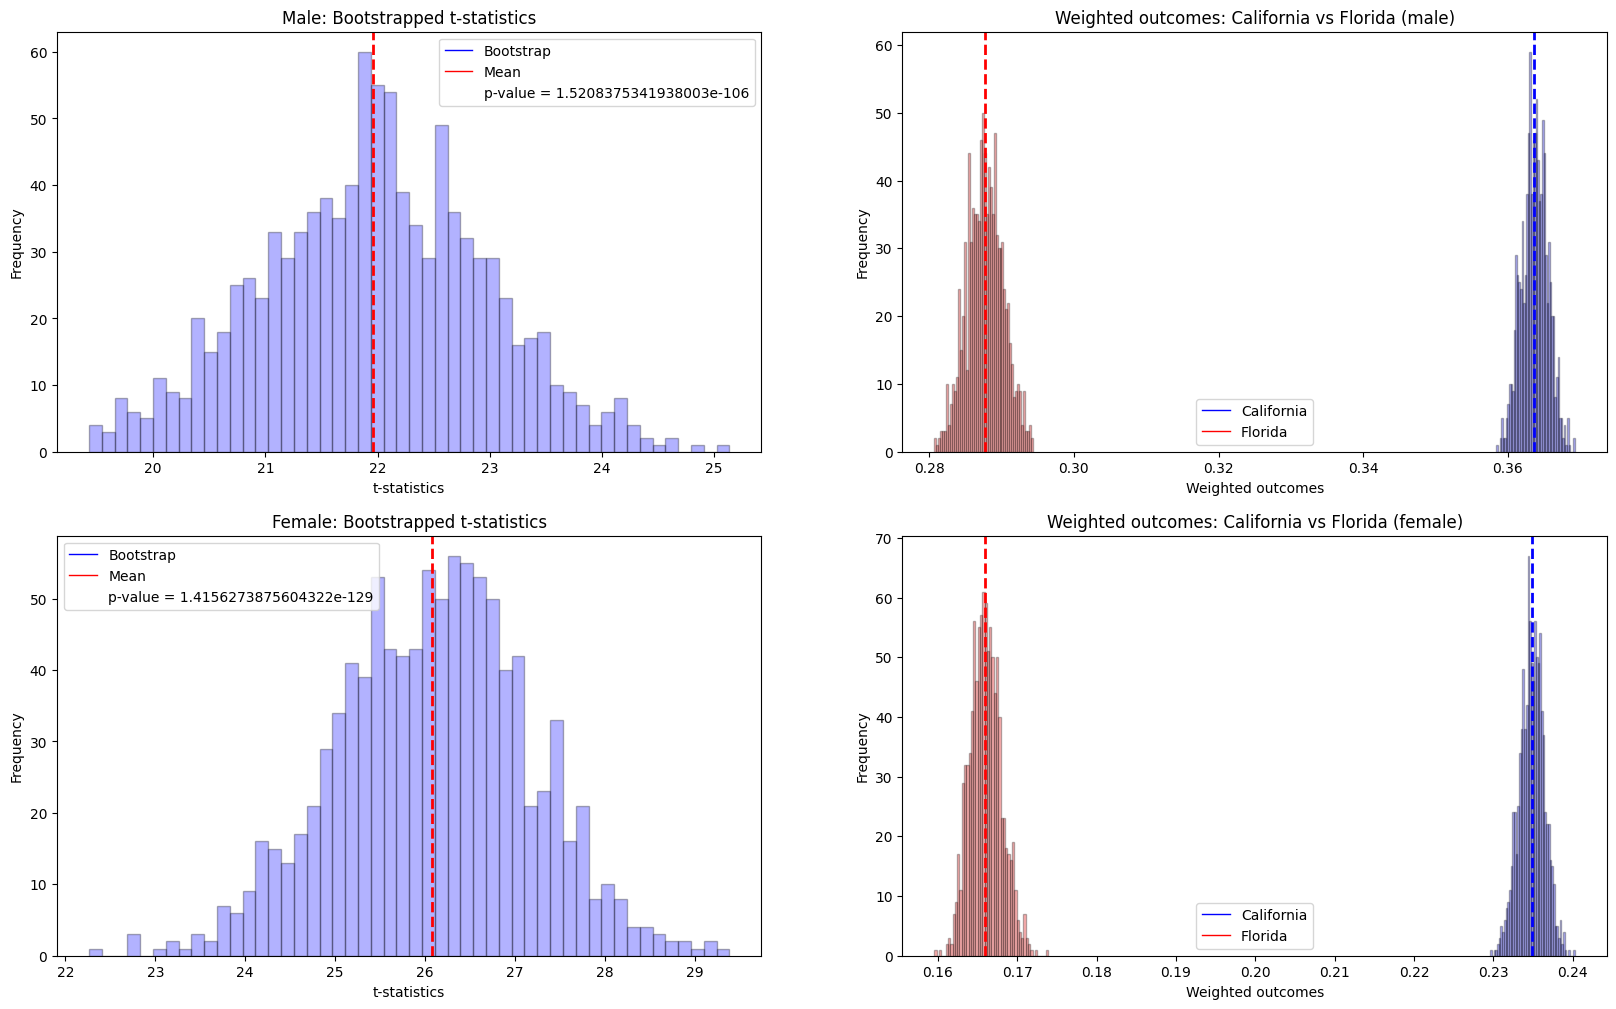

<Figure size 640x480 with 0 Axes>

In [102]:
#Plot the bootstrapped t-statistics and weighted outcomes
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
#Histograms of the differences in weighted outcomes and the weighted outcomes itself
axs[0,0].hist(male_ca_fl_t_stats, bins=50, alpha=0.3, color='blue', edgecolor='black', label = "Bootstrapped")
#Add mean difference as vertical line
axs[0,0].axvline(np.mean(male_ca_fl_t_stats), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[0,0].set_title('Male: Bootstrapped t-statistics')
axs[0,0].set_xlabel('t-statistics')
axs[0,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[0,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {male_ca_fl_p_value}')])  

axs[0,1].hist(male_ca_fl_weighted_outcome[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[0,1].hist(male_ca_fl_weighted_outcome[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[0,1].axvline(np.mean(male_ca_fl_weighted_outcome[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean California')
axs[0,1].axvline(np.mean(male_ca_fl_weighted_outcome[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Florida')
axs[0,1].set_title('Weighted outcomes: California vs Florida (male)')
axs[0,1].set_xlabel('Weighted outcomes')
axs[0,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='California'), plt.Line2D([0], [0], color='red', lw=1, label='Florida')]
axs[0,1].legend(handles=handles)

axs[1,0].hist(female_ca_fl_t_stats, bins=50, alpha=0.3, color='blue', edgecolor='black')
#Add mean difference as vertical line
axs[1,0].axvline(np.mean(female_ca_fl_t_stats), color='red', linestyle='dashed', linewidth=2, label='Mean')
axs[1,0].set_title('Female: Bootstrapped t-statistics')
axs[1,0].set_xlabel('t-statistics')
axs[1,0].set_ylabel('Frequency')
#Add mean values to legend and p-values
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='Bootstrap'), plt.Line2D([0], [0], color='red', lw=1, label='Mean')]
axs[1,0].legend(handles=handles + [plt.Line2D([0], [0], color='none', lw=1, label=f'p-value = {female_ca_fl_p_value}')])

axs[1,1].hist(female_ca_fl_weighted_outcome[0], bins=50, alpha=0.3, color='blue', edgecolor='black')
axs[1,1].hist(female_ca_fl_weighted_outcome[1], bins=50, alpha=0.3, color='red', edgecolor='black')
#Add mean values as vertical lines
axs[1,1].axvline(np.mean(female_ca_fl_weighted_outcome[0]), color='blue', linestyle='dashed', linewidth=2, label='Mean California')
axs[1,1].axvline(np.mean(female_ca_fl_weighted_outcome[1]), color='red', linestyle='dashed', linewidth=2, label='Mean Florida')
axs[1,1].set_title('Weighted outcomes: California vs Florida (female)')
axs[1,1].set_xlabel('Weighted outcomes')
axs[1,1].set_ylabel('Frequency')
#Add mean values to legend
handles = [plt.Line2D([0], [0], color='blue', lw=1, label='California'), plt.Line2D([0], [0], color='red', lw=1, label='Florida')]
axs[1,1].legend(handles=handles)
plt.show()
plt.tight_layout()


,PINCP,AGEP,RAC1P,MAR,SCHL,SEX
0,0,60-80,1,1,3,1
1,0,0-20,1,5,3,1
2,0,20-40,1,5,3,1
3,0,0-20,1,5,3,1
4,0,60-80,0,5,0,1
...,...,...,...,...,...,...
172521,0,40-60,0,1,3,1
172524,0,40-60,0,1,4,1
172525,0,40-60,0,1,6,1
172527,0,40-60,1,1,3,1


In [100]:
#Unique combinations of marital and education status
ca_df['MAR_SCHL'] = ca_df['MAR'].astype(str) + '_' + ca_df['SCHL'].astype(str)
fl_df['MAR_SCHL'] = fl_df['MAR'].astype(str) + '_' + fl_df['SCHL'].astype(str)
male_ca_df['MAR_SCHL'] = male_ca_df['MAR'].astype(str) + '_' + male_ca_df['SCHL'].astype(str)
male_fl_df['MAR_SCHL'] = male_fl_df['MAR'].astype(str) + '_' + male_fl_df['SCHL'].astype(str)
female_ca_df['MAR_SCHL'] = female_ca_df['MAR'].astype(str) + '_' + female_ca_df['SCHL'].astype(str)
female_fl_df['MAR_SCHL'] = female_fl_df['MAR'].astype(str) + '_' + female_fl_df['SCHL'].astype(str)

male_probs_ca = np.empty((len(ca_df['MAR_SCHL'].unique()), len(ca_df['Age_Race'])))
male_probs_fl = np.empty((len(fl_df['MAR_SCHL'].unique()), len(fl_df['Age_Race'])))

male_probs_ca.shape,male_probs_fl.shape


                                                       

((40, 312816), (40, 172529))

We can test P(age,race) and their conditional versions based on SEX, by using Chi-Squared Testing.

In [60]:
#Unique combinations of age,race
ca_df['Age_Race'] = ca_df['AGEP'].astype(str) + '_' + ca_df['RAC1P'].astype(str)
male_ca_df['Age_Race'] = male_ca_df['AGEP'].astype(str) + '_' + male_ca_df['RAC1P'].astype(str)
female_ca_df['Age_Race'] = female_ca_df['AGEP'].astype(str) + '_' + female_ca_df['RAC1P'].astype(str)
fl_df['Age_Race'] = fl_df['AGEP'].astype(str) + '_' + fl_df['RAC1P'].astype(str)
male_fl_df['Age_Race'] = male_fl_df['AGEP'].astype(str) + '_' + male_fl_df['RAC1P'].astype(str)
female_fl_df['Age_Race'] = female_fl_df['AGEP'].astype(str) + '_' + female_fl_df['RAC1P'].astype(str)
##Create all possible contingency tables
pooled_ca_fl_df = pd.concat([ca_df,fl_df])
pooled_ca_fl_df['Sample'] = ['California'] * ca_df.shape[0] + ['Florida'] * fl_df.shape[0]
contingency_ca_fl = pd.crosstab(pooled_ca_fl_df['Age_Race'], pooled_ca_fl_df['Sample'])
pooled_male_ca_fl_df = pd.concat([male_ca_df,male_fl_df])
pooled_male_ca_fl_df['Sample'] = ['California']*male_ca_df.shape[0] + ['Florida']*male_fl_df.shape[0]
pooled_female_ca_fl_df = pd.concat([female_ca_df,female_fl_df])
pooled_female_ca_fl_df['Sample'] = ['California']*female_ca_df.shape[0] + ['Florida']*female_fl_df.shape[0]
contingency_male_ca_fl = pd.crosstab(pooled_male_ca_fl_df['Age_Race'], pooled_male_ca_fl_df['Sample'])
contingency_female_ca_fl = pd.crosstab(pooled_female_ca_fl_df['Age_Race'], pooled_female_ca_fl_df['Sample'])
##Compute the chi-square statistics and p-values
chi2_stat_ca_fl, p_val_ca_fl, _, _ = chi2_contingency(contingency_ca_fl)
chi2_stat_male_ca_fl, p_val_male_ca_fl,_,_ = chi2_contingency(contingency_male_ca_fl)
chi2_stat_female_ca_fl, p_val_female_ca_fl,_,_ = chi2_contingency(contingency_female_ca_fl)
##Print results
print(f'California vs Florida: Chi-square statistic = {chi2_stat_ca_fl:.2f}, p-value = {p_val_ca_fl:.2f}')
print(f'California vs Florida (male): Chi-square statistic = {chi2_stat_male_ca_fl:.2f}, p-value = {p_val_male_ca_fl:.2f}')
print(f'California vs Florida (female): Chi-square statistic = {chi2_stat_female_ca_fl:.2f}, p-value = {p_val_female_ca_fl:.2f}')


California vs Florida: Chi-square statistic = 21285.02, p-value = 0.00
California vs Florida (male): Chi-square statistic = 10255.76, p-value = 0.00
California vs Florida (female): Chi-square statistic = 11035.29, p-value = 0.00


In [29]:
11/40

0.275